In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
import vector
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict
import seaborn as sns

import tensorflow as tf
import tensorflow.saved_model
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Add, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model, model_from_json, load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from lbn import LBN, LBNLayer

import mplhep as hep
hep.style.use("CMS")

In [2]:
import logging
def setup_logger(log_file):
    # Create a logger                                                                                                                                                             
    logger = logging.getLogger('main')
    logger.setLevel(logging.DEBUG)

    # Create a file handler                                                                                                                                                       
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(logging.DEBUG)

    # Create a console handler                                                                                                                                                    
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.DEBUG)

    # Create a formatter and add it to the file handler                                                                                                                           
    formatter = logging.Formatter('%(asctime)s,%(msecs)03d %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s','%Y-%m-%d:%H:%M:%S')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)

    # Add the file handler to the logger                                                                                                                                          
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    return logger

In [3]:
tf.__version__
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
tag_ = "LBNResNet_Higgs_Flat_May01"
tagdir = os.path.join(os.getcwd(), tag_)
if not os.path.exists(tagdir):
    os.mkdir(tagdir)
else:
    print(f"{tag_} exists")

In [5]:
dttag = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
n_particles = 10
lbn_feat_names = ["E", "px", "py", "pz", "pt", "eta", "phi", "p", "m", "pair_cos","pair_dr"]
train = False
nepochs = 300
evaluate = True
#hereismodel = f"{tagdir}/training_20240426-125220/cp.ckpt"
hereismodeldir = os.path.join(os.getcwd(), "LBNResNet_Higgs_Flat_Apr29")
hereismodel = f"{hereismodeldir}/training_20240429_103424/cp.ckpt"

runlogdir = os.path.join(tagdir, "runlogs")

if not os.path.exists(runlogdir):
    os.mkdir(runlogdir)

logger = setup_logger(os.path.join(runlogdir, f"runlog_{dttag}.log"))

In [6]:
logger.info(f"date-time      : {dttag}")
logger.info(f"nLBNPart       : {n_particles}")
logger.info(f"lbn feat names : {str(lbn_feat_names)}")
logger.info(f"do train       : {train}")
logger.info(f"nEpochs        : {nepochs}")
logger.info(f"model loded    : {hereismodel}")
logger.info(f"Out dir        : {tagdir}")

2024-05-01:14:21:19,687 INFO     [2392080563.py:1] date-time      : 20240501_142119
2024-05-01:14:21:19,687 INFO     [2392080563.py:2] nLBNPart       : 10
2024-05-01:14:21:19,687 INFO     [2392080563.py:3] lbn feat names : ['E', 'px', 'py', 'pz', 'pt', 'eta', 'phi', 'p', 'm', 'pair_cos', 'pair_dr']
2024-05-01:14:21:19,688 INFO     [2392080563.py:4] do train       : False
2024-05-01:14:21:19,688 INFO     [2392080563.py:5] nEpochs        : 300
2024-05-01:14:21:19,688 INFO     [2392080563.py:6] model loded    : /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_Apr29/training_20240429_103424/cp.ckpt
2024-05-01:14:21:19,688 INFO     [2392080563.py:7] Out dir        : /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01


In [7]:
#df_ = "GluGluHToTauTauSMdata_ForTrain_Raw_11_simple_IC_20240417_183354.h5"
df_ = "GluGluHToTauTau_ForTrain_Raw_11_simple_MB_20240501_082537.h5"
#df_ = "GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908.h5"
#df_ = "Flat_GluGluHToTauTauSMdata_ForTrain_Raw_11_simple_IC_20240418_192329.h5"


#df_ = "GluGluHToTauTauSMdata_ForTrain_Raw_11_simple_IC_20240416_133720.h5"
#df_ = "GluGluHToTauTauSMdata_ForTrain_Raw_11_simple_MB_20240416_145614.h5"
#df_ = "Flat_GluGluHToTauTauSMdata_ForTrain_Raw_11_simple_IC_20240417_064445.h5"




df_tag_ = f"""{df_.split(".")[0]}_nPart_{n_particles}_executed_on_{dttag}"""

In [8]:
logger.info(f"dataframe      : {df_}")

2024-05-01:14:21:19,693 INFO     [776286069.py:1] dataframe      : GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908.h5


In [9]:
# Load the TensorBoard notebook extension
#%reload_ext tensorboard
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances
## Control TensorBoard display. If no port is provided, 
## the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000)

In [10]:
def PlotHistory(history, path=None, df_tag_=df_tag_):
    """ Takes history from Keras training and makes loss plots (batch and epoch) and learning rate plots """
    #----- Figure -----#
    variables = sorted([key for key in history.epochs.keys() if 'val' not in key and 'val_'+key in history.epochs.keys()])
    variables += ["lr"]
    N = len(variables)
    print(f"variables: {variables}")
    fig, ax = plt.subplots(N,2,figsize=(12.5,N*2),sharex='col')
    plt.subplots_adjust(left    = 0.1,
                        right   = 0.6,
                        top     = 0.9,
                        bottom  = 0.1,
                        hspace  = 0.5,
                        wspace  = 0.4)
    
    #----- Batch Plots -----#
    for i,var in enumerate(variables):
        ax[i,0].plot(history.batches['batch'],history.batches[var],'k')
        ax[i,0].set_title(var)
        ax[i,0].set_xlabel('Batch')
        
    #----- Epoch Plots -----#
    for i,var in enumerate(variables):
        ax[i,1].plot(history.epochs['epoch'],history.epochs[var],label='train')
        if 'val_'+var in history.epochs.keys():
            ax[i,1].plot(history.epochs['epoch'],history.epochs['val_'+var],label='validation')
        ax[i,1].set_title(var)
        ax[i,1].legend()
        ax[i,1].set_xlabel('Epoch')

    png_name = os.path.join(path,f'Loss_Acc_LR_{df_tag_}.png')
    logger.info(f"Plot saved: {png_name}")
    fig.savefig(png_name, dpi=300)
    print('Curves saved as %s'%png_name)
#######################################################


def getp4(df, vars=[], LVtype=""):
    """
        df: The main dfataframe
        vars = [p4 components of obj]
        LVtype = ptetaphim / pxpypze
    """
    for var in vars:
        if var not in list(df.keys()):
            df[var] = 0.0
    p4 = None
    if LVtype == "ptetaphim":
        p4 = vector.array({"pt": df[vars[0]].to_numpy(),
                           "eta": df[vars[1]].to_numpy(),
                           "phi": df[vars[2]].to_numpy(),
                           "M": df[vars[3]].to_numpy()})
    elif LVtype == "pxpypze":
        p4 = vector.array({"px": df[vars[0]].to_numpy(),
                           "py": df[vars[1]].to_numpy(),
                           "pz": df[vars[2]].to_numpy(),
                           "E": df[vars[3]].to_numpy()})
        

    return p4

def setp4(df, vars=[]):
    p4 = getp4(df, vars=vars)
    obj = vars[0].split('_')[0]
    num = vars[0].split('_')[1]
    key = f'{obj}_{num}' if len(vars[0].split('_')) > 2 else f'{obj}'

    df[f'{key}_px'] = p4.px
    df[f'{key}_py'] = p4.py
    df[f'{key}_pz'] = p4.pz
    df[f'{key}_E']  = p4.E

In [11]:
#indf = "df_DY_v5_processed_scaled_metphi.h5"
#indf = "df_DY_v5_processed.h5"
indf = f"/Users/gsaha/Work/IPHC/MachineLearning/TauML/Input/{df_}"
df = pd.read_hdf(indf)
#df = df.drop(columns=["total_tau_phi"]) # new
df = df.dropna()
df.head(10)

,npf_tau_1,npf_tau_2,ptfrac_tau_1,ptfrac_tau_2,pf_dphi_pt_frac_tau_1,pf_dphi_pt_frac_tau_2,pf_deta_pt_frac_tau_1,pf_deta_pt_frac_tau_2,pt_tau_1,pt_tau_2,ptCorrPNet_tau_1,ptCorrPNet_tau_2,eta_tau_1,eta_tau_2,phi_tau_1,phi_tau_2,mass_tau_1,mass_tau_2,dxy_tau_1,dxy_tau_2,dz_tau_1,dz_tau_2,rawDeepTau2018v2p5VSe_tau_1,rawDeepTau2018v2p5VSe_tau_2,rawDeepTau2018v2p5VSjet_tau_1,rawDeepTau2018v2p5VSjet_tau_2,rawDeepTau2018v2p5VSmu_tau_1,rawDeepTau2018v2p5VSmu_tau_2,rawIsodR03_tau_1,rawIsodR03_tau_2,rawMVAnewDM2017v2_tau_1,rawMVAnewDM2017v2_tau_2,leadTkPtOverTauPt_tau_1,leadTkPtOverTauPt_tau_2,rawPNetVSe_tau_1,rawPNetVSe_tau_2,rawPNetVSjet_tau_1,rawPNetVSjet_tau_2,rawPNetVSmu_tau_1,rawPNetVSmu_tau_2,charge_tau_1,charge_-1_tau_1,charge_1_tau_1,charge_tau_2,charge_-1_tau_2,charge_1_tau_2,decayModePNet_tau_1,decayModePNet_-1_tau_1,decayModePNet_0_tau_1,decayModePNet_1_tau_1,decayModePNet_2_tau_1,decayModePNet_10_tau_1,decayModePNet_11_tau_1,decayModePNet_tau_2,decayModePNet_-1_tau_2,decayModePNet_0_tau_2,decayModePNet_1_tau_2,decayModePNet_2_tau_2,decayModePNet_10_tau_2,decayModePNet_11_tau_2,probDM0PNet_tau_1,probDM0PNet_tau_2,probDM10PNet_tau_1,probDM10PNet_tau_2,probDM11PNet_tau_1,probDM11PNet_tau_2,probDM1PNet_tau_1,probDM1PNet_tau_2,probDM2PNet_tau_1,probDM2PNet_tau_2,pt_tau1prod_1,pt_tau1prod_2,pt_tau1prod_3,pt_tau1prod_4,pt_tau1prod_5,pt_tau1prod_6,pt_tau1prod_7,pt_tau1prod_8,pt_tau1prod_9,pt_tau1prod_10,eta_tau1prod_1,eta_tau1prod_2,eta_tau1prod_3,eta_tau1prod_4,eta_tau1prod_5,eta_tau1prod_6,eta_tau1prod_7,eta_tau1prod_8,eta_tau1prod_9,eta_tau1prod_10,phi_tau1prod_1,phi_tau1prod_2,phi_tau1prod_3,phi_tau1prod_4,phi_tau1prod_5,phi_tau1prod_6,phi_tau1prod_7,phi_tau1prod_8,phi_tau1prod_9,phi_tau1prod_10,mass_tau1prod_1,mass_tau1prod_2,mass_tau1prod_3,mass_tau1prod_4,mass_tau1prod_5,mass_tau1prod_6,mass_tau1prod_7,mass_tau1prod_8,mass_tau1prod_9,mass_tau1prod_10,pdgId_tau1prod_1,pdgId_tau1prod_2,pdgId_tau1prod_3,pdgId_tau1prod_4,pdgId_tau1prod_5,pdgId_tau1prod_6,pdgId_tau1prod_7,pdgId_tau1prod_8,pdgId_tau1prod_9,pdgId_tau1prod_10,charge_tau1prod_1,charge_tau1prod_2,charge_tau1prod_3,charge_tau1prod_4,charge_tau1prod_5,charge_tau1prod_6,charge_tau1prod_7,charge_tau1prod_8,charge_tau1prod_9,charge_tau1prod_10,pt_tau2prod_1,pt_tau2prod_2,pt_tau2prod_3,pt_tau2prod_4,pt_tau2prod_5,pt_tau2prod_6,pt_tau2prod_7,pt_tau2prod_8,pt_tau2prod_9,pt_tau2prod_10,eta_tau2prod_1,eta_tau2prod_2,eta_tau2prod_3,eta_tau2prod_4,eta_tau2prod_5,eta_tau2prod_6,eta_tau2prod_7,eta_tau2prod_8,eta_tau2prod_9,eta_tau2prod_10,phi_tau2prod_1,phi_tau2prod_2,phi_tau2prod_3,phi_tau2prod_4,phi_tau2prod_5,phi_tau2prod_6,phi_tau2prod_7,phi_tau2prod_8,phi_tau2prod_9,phi_tau2prod_10,mass_tau2prod_1,mass_tau2prod_2,mass_tau2prod_3,mass_tau2prod_4,mass_tau2prod_5,mass_tau2prod_6,mass_tau2prod_7,mass_tau2prod_8,mass_tau2prod_9,mass_tau2prod_10,pdgId_tau2prod_1,pdgId_tau2prod_2,pdgId_tau2prod_3,pdgId_tau2prod_4,pdgId_tau2prod_5,pdgId_tau2prod_6,pdgId_tau2prod_7,pdgId_tau2prod_8,pdgId_tau2prod_9,pdgId_tau2prod_10,charge_tau2prod_1,charge_tau2prod_2,charge_tau2prod_3,charge_tau2prod_4,charge_tau2prod_5,charge_tau2prod_6,charge_tau2prod_7,charge_tau2prod_8,charge_tau2prod_9,charge_tau2prod_10,pt_jet_1,pt_jet_2,pt_jet_3,pt_jet_4,pt_jet_5,pt_jet_6,pt_jet_7,pt_jet_8,pt_jet_9,pt_jet_10,eta_jet_1,eta_jet_2,eta_jet_3,eta_jet_4,eta_jet_5,eta_jet_6,eta_jet_7,eta_jet_8,eta_jet_9,eta_jet_10,phi_jet_1,phi_jet_2,phi_jet_3,phi_jet_4,phi_jet_5,phi_jet_6,phi_jet_7,phi_jet_8,phi_jet_9,phi_jet_10,mass_jet_1,mass_jet_2,mass_jet_3,mass_jet_4,mass_jet_5,mass_jet_6,mass_jet_7,mass_jet_8,mass_jet_9,mass_jet_10,btagPNetB_jet_1,btagPNetB_jet_2,btagPNetB_jet_3,btagPNetB_jet_4,btagPNetB_jet_5,btagPNetB_jet_6,btagPNetB_jet_7,btagPNetB_jet_8,btagPNetB_jet_9,btagPNetB_jet_10,btagDeepFlavB_jet_1,btagDeepFlavB_jet_2,btagDeepFlavB_jet_3,btagDeepFlavB_jet_4,btagDeepFlavB_jet_5,btagDeepFlavB_jet_6,btagDeepFlavB_jet_7,btagDeepFlavB_jet_8,btagDeepFlavB_jet_9,btagDeepFlavB_jet_10,pt_MET,phi_MET,covXX_MET,covXY_MET,covYY_

In [12]:
df["ptlog_gentau_1"] = np.log(df["pt_gentau_1"])
df["ptlog_gentau_2"] = np.log(df["pt_gentau_2"])

In [13]:
#hasnan = list(df.isnull().any())
#for i, col in enumerate(df.keys()):
#    print(f"{col}:\t\t {hasnan[i]}")

In [14]:
#import awkward as ak
#arr = ak.Array((df["rawPNetVSe_tau_1"]).to_numpy())
#ak.to_list(ak.sort(arr))

In [15]:
logger.info(f"df keys         :\n{list(df.keys())}")

2024-05-01:14:21:20,675 INFO     [1491129398.py:1] df keys         :
['npf_tau_1', 'npf_tau_2', 'ptfrac_tau_1', 'ptfrac_tau_2', 'pf_dphi_pt_frac_tau_1', 'pf_dphi_pt_frac_tau_2', 'pf_deta_pt_frac_tau_1', 'pf_deta_pt_frac_tau_2', 'pt_tau_1', 'pt_tau_2', 'ptCorrPNet_tau_1', 'ptCorrPNet_tau_2', 'eta_tau_1', 'eta_tau_2', 'phi_tau_1', 'phi_tau_2', 'mass_tau_1', 'mass_tau_2', 'dxy_tau_1', 'dxy_tau_2', 'dz_tau_1', 'dz_tau_2', 'rawDeepTau2018v2p5VSe_tau_1', 'rawDeepTau2018v2p5VSe_tau_2', 'rawDeepTau2018v2p5VSjet_tau_1', 'rawDeepTau2018v2p5VSjet_tau_2', 'rawDeepTau2018v2p5VSmu_tau_1', 'rawDeepTau2018v2p5VSmu_tau_2', 'rawIsodR03_tau_1', 'rawIsodR03_tau_2', 'rawMVAnewDM2017v2_tau_1', 'rawMVAnewDM2017v2_tau_2', 'leadTkPtOverTauPt_tau_1', 'leadTkPtOverTauPt_tau_2', 'rawPNetVSe_tau_1', 'rawPNetVSe_tau_2', 'rawPNetVSjet_tau_1', 'rawPNetVSjet_tau_2', 'rawPNetVSmu_tau_1', 'rawPNetVSmu_tau_2', 'charge_tau_1', 'charge_-1_tau_1', 'charge_1_tau_1', 'charge_tau_2', 'charge_-1_tau_2', 'charge_1_tau_2', 'decay

In [16]:
num_keys   = ['pt_tau_1', 'pt_tau_2','eta_tau_1', 'eta_tau_2', 'phi_tau_1', 'phi_tau_2',
              'mass_tau_1', 'mass_tau_2', #'dxy_tau_1', 'dxy_tau_2', 'dz_tau_1', 'dz_tau_2',
              #'rawIsodR03_tau_1', 'rawIsodR03_tau_2', # new 
              #'leadTkPtOverTauPt_tau_1',  # new
              #'leadTkPtOverTauPt_tau_2',  # new
              #'rawPNetVSe_tau_1', 'rawPNetVSe_tau_2', # new
              #'rawPNetVSjet_tau_1', 'rawPNetVSjet_tau_2', # new
              #'rawPNetVSmu_tau_1', 'rawPNetVSmu_tau_2', # new
              #'probDM0PNet_tau_1', 'probDM0PNet_tau_2',
              #'probDM1PNet_tau_1', 'probDM1PNet_tau_2', # new
              #'probDM2PNet_tau_1', 'probDM2PNet_tau_2',
              #'probDM10PNet_tau_1', 'probDM10PNet_tau_2',
              #'probDM11PNet_tau_1', 'probDM11PNet_tau_2',
              'pt_jet_1', 'pt_jet_2', 'pt_jet_3', 'pt_jet_4',
              'eta_jet_1', 'eta_jet_2', 'eta_jet_3', 'eta_jet_4',
              'phi_jet_1', 'phi_jet_2', 'phi_jet_3', 'phi_jet_4',
              'mass_jet_1', 'mass_jet_2', 'mass_jet_3', 'mass_jet_4',
              #'btagPNetB_jet_1', 'btagPNetB_jet_2', 'btagPNetB_jet_3', 'btagPNetB_jet_4',
              'npf_tau_1', 'npf_tau_2',   ## NEW !!
              'ptfrac_tau_1', 'ptfrac_tau_2',  ## NEW !!
              #'pf_dphi_pt_frac_tau_1', 'pf_dphi_pt_frac_tau_2', 
              #'pf_deta_pt_frac_tau_1', 'pf_deta_pt_frac_tau_2', 
              'pt_MET', 'phi_MET', 
              'covXX_MET', 'covXY_MET', 'covYY_MET', 'sumEt_MET',  # new
              'significance_MET',  # new
              #'nJet', 
              #'nPV', 
              #'HT', #'MT_total'
             ]
cat_keys = ['charge_-1_tau_1','charge_1_tau_1',
            'charge_-1_tau_2','charge_1_tau_2',
            #'decayModePNet_0_tau_1', 'decayModePNet_1_tau_1', 'decayModePNet_2_tau_1', ## NEW !!
            #'decayModePNet_10_tau_1', 'decayModePNet_11_tau_1', ## NEW !!
            #'decayModePNet_0_tau_2', 'decayModePNet_1_tau_2', 'decayModePNet_2_tau_2', ## NEW !!
            #'decayModePNet_10_tau_2', 'decayModePNet_11_tau_2' ## NEW !!
           ]
target_keys = ['ptlog_gentau_1', 'eta_gentau_1', 'phi_gentau_1', 
               'ptlog_gentau_2', 'eta_gentau_2', 'phi_gentau_2']
#               'k1x', 'k1y', 'k1z',
#               'k2x', 'k2y', 'k2z']
#target_keys = ['h1x', 'h1y', 'h1z',
#               'h2x', 'h2y', 'h2z']

extra_keys = ["pt_tau1pi_1","eta_tau1pi_1","phi_tau1pi_1","mass_tau1pi_1",
              "pt_tau2pi_1","eta_tau2pi_1","phi_tau2pi_1","mass_tau2pi_1",
              "pt_tau1pi0_1","eta_tau1pi0_1","phi_tau1pi0_1","mass_tau1pi0_1",
              "pt_tau2pi0_1","eta_tau2pi0_1","phi_tau2pi0_1","mass_tau2pi0_1",
              "phicp", "phi_cp_det",
              'pt_gentau_1', #'eta_gentau_1', 'phi_gentau_1', 
              'pt_gentau_2', #'eta_gentau_2', 'phi_gentau_2',
              'h1x', 'h1y', 'h1z', 'h2x', 'h2y', 'h2z',
              'k1x', 'k1y', 'k1z', 'k2x', 'k2y', 'k2z',
             ]
keysTokeep = num_keys + cat_keys + target_keys + extra_keys

In [17]:
logger.info(f"main features        : {str(num_keys+cat_keys)}")
logger.info(f"targets              : {str(target_keys)}")
logger.info(f"extra                : {str(extra_keys)}")

2024-05-01:14:21:20,681 INFO     [2678812420.py:1] main features        : ['pt_tau_1', 'pt_tau_2', 'eta_tau_1', 'eta_tau_2', 'phi_tau_1', 'phi_tau_2', 'mass_tau_1', 'mass_tau_2', 'pt_jet_1', 'pt_jet_2', 'pt_jet_3', 'pt_jet_4', 'eta_jet_1', 'eta_jet_2', 'eta_jet_3', 'eta_jet_4', 'phi_jet_1', 'phi_jet_2', 'phi_jet_3', 'phi_jet_4', 'mass_jet_1', 'mass_jet_2', 'mass_jet_3', 'mass_jet_4', 'npf_tau_1', 'npf_tau_2', 'ptfrac_tau_1', 'ptfrac_tau_2', 'pt_MET', 'phi_MET', 'covXX_MET', 'covXY_MET', 'covYY_MET', 'sumEt_MET', 'significance_MET', 'charge_-1_tau_1', 'charge_1_tau_1', 'charge_-1_tau_2', 'charge_1_tau_2']
2024-05-01:14:21:20,681 INFO     [2678812420.py:2] targets              : ['ptlog_gentau_1', 'eta_gentau_1', 'phi_gentau_1', 'ptlog_gentau_2', 'eta_gentau_2', 'phi_gentau_2']
2024-05-01:14:21:20,681 INFO     [2678812420.py:3] extra                : ['pt_tau1pi_1', 'eta_tau1pi_1', 'phi_tau1pi_1', 'mass_tau1pi_1', 'pt_tau2pi_1', 'eta_tau2pi_1', 'phi_tau2pi_1', 'mass_tau2pi_1', 'pt_tau1pi

In [18]:
df = df[keysTokeep]

In [19]:
tau1p4 = getp4(df, vars=["pt_tau_1", "eta_tau_1", "phi_tau_1", "mass_tau_1"], LVtype="ptetaphim")
tau2p4 = getp4(df, vars=["pt_tau_2", "eta_tau_2", "phi_tau_2", "mass_tau_2"], LVtype="ptetaphim")

tausp4 = tau1p4 + tau2p4
print(tausp4.mass)
#plt.hist(tausp4.mass, bins=100, range=[30,130])
#plt.show()
#df["H_vism"] = tausp4.mass
#target_keys = target_keys + ["H_vism"]

[101.43848779  73.965667   100.83001684 ...  98.7749031   72.96057439
 100.70184384]


In [20]:
#df_train, df_test = train_test_split(df,  test_size=0.2,  random_state=42, shuffle=True)
df_train, df_test = train_test_split(df,  test_size=0.2,  shuffle=False)

In [21]:
df_train_x = df_train.drop(columns=target_keys+extra_keys)
df_train_y = df_train[target_keys]

df_test_x = df_test.drop(columns=target_keys+extra_keys)
df_test_y = df_test[target_keys]

#df2_met_raw_phi_train = df_train_x[["met_phi_raw"]]
#df2_met_raw_phi_test  = df_test_x[["met_phi_raw"]]
#df_train_x = df_train_x.drop(columns=["met_phi_raw"])
#df_test_x = df_test_x.drop(columns=["met_phi_raw"])

feats = list(df_train_x.keys())

In [22]:
if evaluate:
    df = pd.concat([df_train, df_test], axis=0)

In [23]:
df_train_x

,pt_tau_1,pt_tau_2,eta_tau_1,eta_tau_2,phi_tau_1,phi_tau_2,mass_tau_1,mass_tau_2,pt_jet_1,pt_jet_2,pt_jet_3,pt_jet_4,eta_jet_1,eta_jet_2,eta_jet_3,eta_jet_4,phi_jet_1,phi_jet_2,phi_jet_3,phi_jet_4,mass_jet_1,mass_jet_2,mass_jet_3,mass_jet_4,npf_tau_1,npf_tau_2,ptfrac_tau_1,ptfrac_tau_2,pt_MET,phi_MET,covXX_MET,covXY_MET,covYY_MET,sumEt_MET,significance_MET,charge_-1_tau_1,charge_1_tau_1,charge_-1_tau_2,charge_1_tau_2
0,56.754528,35.064426,-1.060791,-0.026447,0.574463,-2.564941,0.805176,0.878906,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.0,2.0,1.000781,1.000279,53.132923,-2.277344,330.0,67.75000,284.0,674.0,7.722656,0.0,1.0,1.0,0.0
1,40.929752,33.084209,1.342041,1.067871,2.825684,-0.123566,0.604004,0.719238,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4.0,3.0,1.000547,1.000466,29.456814,1.061279,542.0,4.06250,692.0,1452.0,1.329102,0.0,1.0,1.0,0.0
2,49.838066,49.697845,1.944824,1.622803,1.869385,-1.301514,0.939941,0.595703,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.0,3.0,1.000330,1.000028,7.774197,1.613525,438.0,-63.75000,638.0,1229.0,0.095032,1.0,0.0,0.0,1.0
3,73.246361,57.675949,0.077606,-0.230988,1.656006,-2.790527,0.717773,0.729492,84.93750,0.0,0.0,0.0,-1.020508,0.0,0.0,0.0,-0.659668,0.0,0.0,0.0,14.359375,0.0,0.0,0.0,2.0,2.0,1.000263,0.999929,3.607110,-2.895508,1396.0,-61.75000,1516.0,2354.0,0.009483,0.0,1.0,1.0,0.0
4,56.222298,53.215492,0.178619,0.600220,-2.957031,0.233917,0.609375,0.932129,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,2.0,1.000284,1.000208,23.089388,2.425293,588.0,4.21875,493.0,1350.0,0.989258,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,49.709141,46.724102,-1.214355,-0.297485,1.254395,-1.554199,0.539062,0.139526,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.0,2.0,0.999761,0.999927,4.655349,2.170410,273.0,31.31250,449.0,799.0,0.063782,1.0,0.0,0.0,1.0
764,67.801712,31.094055,-0.222351,-0.790649,0.621460,-1.824463,0.816895,0.600098,50.28125,0.0,0.0,0.0,-3.920898,0.0,0.0,0.0,-3.068848,0.0,0.0,0.0,9.546875,0.0,0.0,0.0,2.0,2.0,0.999929,1.000241,46.561974,-2.910645,966.0,-25.25000,844.0,2326.0,2.294922,1.0,0.0,0.0,1.0
765,107.808464,83.672478,0.050926,-0.031815,-3.037598,-1.904053,0.139526,0.758789,162.50000,0.0,0.0,0.0,-2.082520,0.0,0.0,0.0,0.565186,0.0,0.0,0.0,15.835938,0.0,0.0,0.0,2.0,2.0,0.999766,0.999666,33.980080,2.560059,656.0,43.62500,370.0,1215.0,2.380859,1.0,0.0,0.0,1.0
766,44.319592,21.431398,-0.549561,-2.115723,0.340332,-2.776367,0.465820,0.558594,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4.0,2.0,1.001647,1.000102,8.402381,-2.263672,497.0,0.00000,497.0,1395.0,0.141968,1.0,0.0,0.0,1.0


In [24]:
df_train_y

,ptlog_gentau_1,eta_gentau_1,phi_gentau_1,ptlog_gentau_2,eta_gentau_2,phi_gentau_2
0,3.907010,-0.044189,-2.562500,4.114964,-1.058594,0.580078
1,4.197202,1.070312,-0.103516,4.064744,1.347656,2.820312
2,4.185860,1.953125,1.859375,4.058286,1.632812,-1.300781
3,4.293878,-0.224609,-2.781250,4.391358,0.084717,1.656250
4,4.234107,0.167480,-2.968750,3.991296,0.599609,0.233398
...,...,...,...,...,...,...
763,4.027581,-1.210938,1.242188,4.060443,-0.287109,-1.558594
764,4.382027,-0.225586,0.613281,3.917011,-0.792969,-1.839844
765,5.059425,0.043823,-3.039062,4.445588,-0.029358,-1.902344
766,3.842137,-0.558594,0.348633,3.881564,-2.101562,-2.796875


In [25]:
df_train_x.keys()

Index(['pt_tau_1', 'pt_tau_2', 'eta_tau_1', 'eta_tau_2', 'phi_tau_1',
       'phi_tau_2', 'mass_tau_1', 'mass_tau_2', 'pt_jet_1', 'pt_jet_2',
       'pt_jet_3', 'pt_jet_4', 'eta_jet_1', 'eta_jet_2', 'eta_jet_3',
       'eta_jet_4', 'phi_jet_1', 'phi_jet_2', 'phi_jet_3', 'phi_jet_4',
       'mass_jet_1', 'mass_jet_2', 'mass_jet_3', 'mass_jet_4', 'npf_tau_1',
       'npf_tau_2', 'ptfrac_tau_1', 'ptfrac_tau_2', 'pt_MET', 'phi_MET',
       'covXX_MET', 'covXY_MET', 'covYY_MET', 'sumEt_MET', 'significance_MET',
       'charge_-1_tau_1', 'charge_1_tau_1', 'charge_-1_tau_2',
       'charge_1_tau_2'],
      dtype='object')

## Data engineering for LBN 

In [26]:
def dataset_LBN():    
    import vector
    df_train_x_copy = df_train_x.copy()
    df_test_x_copy = df_test_x.copy()

    def getp4(df, vars=[]):
        #for var in vars:
        #    if var not in list(df.keys()):
        #        df[var] = 0.0
        p4 = vector.array({"pt": df[vars[0]].to_numpy(),
                           "eta": df[vars[1]].to_numpy() if vars[1] in list(df.keys()) else np.zeros_like(df[vars[0]].to_numpy()),
                           "phi": df[vars[2]].to_numpy() if vars[2] in list(df.keys()) else np.zeros_like(df[vars[0]].to_numpy()),
                           "M": df[vars[3]].to_numpy() if vars[3] in list(df.keys()) else np.zeros_like(df[vars[0]].to_numpy())})

        return p4

    def setp4(df, vars=[]):
        p4 = getp4(df, vars=vars)
        obj = vars[0].split('_')[1]
        num = vars[0].split('_')[-1]
        key = f'{obj}_{num}' if len(vars[0].split('_')) > 2 else f'{obj}'

        df[f'px_{key}'] = p4.px
        df[f'py_{key}'] = p4.py
        df[f'pz_{key}'] = p4.pz
        df[f'E_{key}']  = p4.E



    Basics = [['pt_tau_1','eta_tau_1','phi_tau_1','mass_tau_1'],
              ['pt_tau_2','eta_tau_2','phi_tau_2','mass_tau_2'],
              ['pt_jet_1','eta_jet_1','phi_jet_1','mass_jet_1'],
              ['pt_jet_2','eta_jet_2','phi_jet_2','mass_jet_2'],
              ['pt_jet_3','eta_jet_3','phi_jet_3','mass_jet_3'],
              ['pt_jet_4','eta_jet_4','phi_jet_4','mass_jet_4'],
              ['pt_MET','eta_MET','phi_MET','mass_MET']]

    for varlist in Basics:
        setp4(df_train_x_copy, vars=varlist)
        setp4(df_test_x_copy, vars=varlist)


    DNNsToDrop = np.array(Basics).reshape(-1)    
    #print(DNNsToDrop)

    LBNsToKeep = np.char.replace(DNNsToDrop, "pt", "px")
    LBNsToKeep = np.char.replace(LBNsToKeep, "eta", "py")
    LBNsToKeep = np.char.replace(LBNsToKeep, "phi", "pz")
    LBNsToKeep = np.char.replace(LBNsToKeep, "mass", "E")
    LBNsToKeep = list(LBNsToKeep)
    #print(LBNsToKeep)

    #df_train_x_DNN = df_train_x_copy.drop(columns=list(DNNsToDrop)+LBNsToKeep)
    #df_test_x_DNN = df_test_x_copy.drop(columns=list(DNNsToDrop)+LBNsToKeep)
    df_train_x_DNN = df_train_x_copy.drop(columns=LBNsToKeep)
    df_test_x_DNN = df_test_x_copy.drop(columns=LBNsToKeep)

    df_train_x_LBN = df_train_x_copy[LBNsToKeep]
    df_test_x_LBN  = df_test_x_copy[LBNsToKeep]


    ##df_train_x_DNN
    ##df_train_x_DNN
    ##df_train_x_LBN
    ##df_test_x_LBN
    
    #cols_cat = [x for x in list(df_train_x_DNN.keys()) if x.split('_')[0] == 'cat']
    #cols_num = [x for x in list(df_train_x_DNN.keys()) if x.split('_')[0] != 'cat']
    
    x_train_DNN_numerical = df_train_x_DNN[num_keys].to_numpy()
    x_train_DNN_categorical = df_train_x_DNN[cat_keys].to_numpy()
    x_test_DNN_numerical = df_test_x_DNN[num_keys].to_numpy()
    x_test_DNN_categorical = df_test_x_DNN[cat_keys].to_numpy()

    #x_train_DNN = df_train_x_DNN.to_numpy()
    #x_test_DNN = df_test_x_DNN.to_numpy()

    ### ----- Scaling ----- ###
    scaler1 = preprocessing.StandardScaler()
    x_train_DNN_numerical = scaler1.fit_transform(x_train_DNN_numerical)
    x_test_DNN_numerical  = scaler1.transform(x_test_DNN_numerical)

    x_train_DNN = np.concatenate([x_train_DNN_numerical, x_train_DNN_categorical], axis=1)
    x_test_DNN  = np.concatenate([x_test_DNN_numerical, x_test_DNN_categorical], axis=1)
    ### ------------------- ###
    
    #x_train_DNN = df_train_x_DNN.to_numpy()
    #x_test_DNN  = df_test_x_DNN.to_numpy()
    
    x_train_LBN_ = df_train_x_LBN.to_numpy()
    x_test_LBN_ = df_test_x_LBN.to_numpy()

    ### ----- Scaling ----- ###
    #scaler2 = preprocessing.StandardScaler()
    #x_train_LBN_ = scaler2.fit_transform(x_train_LBN_)
    #x_test_LBN_  = scaler2.transform(x_test_LBN_)
    ### ------------------- ###
    
    x_train_LBN = x_train_LBN_.reshape(-1, x_train_LBN_.shape[-1]//4, 4)
    x_test_LBN = x_test_LBN_.reshape(-1, x_test_LBN_.shape[-1]//4, 4)

    print(x_train_LBN.shape, x_train_DNN.shape)
    print(x_train_LBN.shape, x_test_DNN.shape)
    
    """
    plt.figure(figsize=(20,20))
    for idx, key in enumerate(list(df_train_x_LBN.keys())):
        idx=idx+1
        ax = plt.subplot(7,4,idx)
        arr = x_train_LBN_[:,(idx-1):idx].reshape(-1)
        #print(arr)
        ax.hist(arr, 50, range=[np.min(arr), np.max(arr)], log=True)
        ax.set_title(f"{key}")
    plt.tight_layout()
    """

    feats_DNN = list(df_train_x_DNN.keys())
    
    dict = {'x_train': np.concatenate([x_train_DNN, x_train_LBN_], axis=1),
            'x_test': np.concatenate([x_test_DNN, x_test_LBN_], axis=1),
            'x_train_LBN_keys': list(df_train_x_LBN.keys()),
            'x_train_DNN_keys': list(df_train_x_DNN.keys()),
            'x_train_LBN': x_train_LBN,
            'x_test_LBN': x_test_LBN,
            'x_train_DNN': x_train_DNN,
            'x_test_DNN': x_test_DNN}
    return dict


In [27]:
LBN_dict = dataset_LBN()

feats_name_LBN = LBN_dict['x_train_LBN_keys']
feats_name_DNN = LBN_dict['x_train_DNN_keys']

x_train_LBN =  LBN_dict['x_train_LBN']
x_train_DNN =  LBN_dict['x_train_DNN']
x_test_LBN  =  LBN_dict['x_test_LBN']
x_test_DNN  =  LBN_dict['x_test_DNN']

(171860, 7, 4) (171860, 39)
(171860, 7, 4) (42965, 39)


In [28]:
len(feats_name_DNN), len(feats_name_LBN)

(39, 28)

In [29]:
feats = feats_name_LBN+feats_name_DNN if "LBN" in tag_ else feats
#feats = feats_name_DNN if tag_=="LBN" else feats
len(feats)

67

In [30]:
x_train = df_train_x.to_numpy()
y_train = df_train_y.to_numpy()

x_test = df_test_x.to_numpy()
y_test = df_test_y.to_numpy()

In [ ]:
plt.figure(figsize=(30,24))
for idx in range(y_train.shape[-1]):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr_train = y_train[:,idx-1:idx].reshape(-1)
    arr_test  = y_test [:,idx-1:idx].reshape(-1)

    #print(arr)
    minmax = [-50,50] if idx < 7 else [-1,1]
    ax.hist(arr_train, 100, histtype="stepfilled", alpha=0.7, label='Train', log=False, density=True)
    ax.hist(arr_test,  100, histtype="stepfilled", alpha=0.7, label='Test',  log=False, density=True)
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,f'target_{df_tag_}.png'), dpi=300)
plt.show()

### Normalise targets

In [ ]:
scaler_y = None
"""
scaler_y = preprocessing.StandardScaler()
scale_data = scaler_y.fit(y_train)

y_train = scaler_y.transform(y_train)
y_test  = scaler_y.transform(y_test)
#y_eval  = scaler_y.transform(y_eval)
"""

'\nscaler_y = preprocessing.StandardScaler()\nscale_data = scaler_y.fit(y_train)\n\ny_train = scaler_y.transform(y_train)\ny_test  = scaler_y.transform(y_test)\n#y_eval  = scaler_y.transform(y_eval)\n'

In [ ]:
"""
plt.figure(figsize=(30,24))
for idx in range(y_train.shape[-1]):
    idx=idx+1
    ax = plt.subplot(4,3,idx)
    arr_train = y_train[:,(idx-1):idx].reshape(-1)
    arr_test  = y_test [:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [-3,3] if idx < 7 else [-1,1]
    ax.hist(arr_train, 100, histtype="stepfilled", alpha=0.7, label='Train', log=False, density=True)
    ax.hist(arr_test,  100, histtype="stepfilled", alpha=0.7, label='Test',  log=False, density=True)
    ax.legend()
plt.tight_layout()
#plt.savefig(os.path.join(tagdir,f'output_test_{df_tag_}.png'), dpi=300)
plt.show()
"""

'\nplt.figure(figsize=(30,24))\nfor idx in range(y_train.shape[-1]):\n    idx=idx+1\n    ax = plt.subplot(4,3,idx)\n    arr_train = y_train[:,(idx-1):idx].reshape(-1)\n    arr_test  = y_test [:,(idx-1):idx].reshape(-1)\n\n    #print(arr)\n    minmax = [-3,3] if idx < 7 else [-1,1]\n    ax.hist(arr_train, 100, histtype="stepfilled", alpha=0.7, label=\'Train\', log=False, density=True)\n    ax.hist(arr_test,  100, histtype="stepfilled", alpha=0.7, label=\'Test\',  log=False, density=True)\n    ax.legend()\nplt.tight_layout()\n#plt.savefig(os.path.join(tagdir,f\'output_test_{df_tag_}.png\'), dpi=300)\nplt.show()\n'

In [36]:
features = list(df_train_x.keys())
print(len(features))
targets = list(df_train_y.keys())
print(len(targets))

39
6


In [37]:
inputs_all = []
for feat in feats:
    #print(feat)
    input_layer = Input(shape=(1,), name=feat)
    inputs_all.append(input_layer)
#print(inputs_all)
#print(len(inputs_all))
#print(inputs_all[1].shape)

all_features = tensorflow.keras.layers.concatenate(inputs_all,axis=-1,name="Features")

In [38]:
all_features

<KerasTensor: shape=(None, 67) dtype=float32 (created by layer 'Features')>

In [39]:
all_features[0][-1]

<KerasTensor: shape=() dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [40]:
def buildmodel_DNN(input_layers, features):
    print("Building a DNN model")
    x = Dense(512, input_dim=features.shape[-1], activation='selu',
              kernel_regularizer=regularizers.l2(0.001))(features)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(7)(x)

    model_inputs = [input_layers]
    model = Model(inputs=model_inputs, outputs=[x])

    return model

In [41]:
def identity_block(X, layerinfo):
    X_shortcut = X
    for i, nodes in enumerate(layerinfo):
        X = Dense(nodes, kernel_regularizer=regularizers.l2(0.001))(X)
        X = Activation('selu')(X)
        X = BatchNormalization()(X)

    X = Add()([X, X_shortcut])
    X = Activation('selu')(X)

    return X

def conv_block(X, layerinfo):
    X_shortcut = X
    for i, nodes in enumerate(layerinfo):
        X = Dense(nodes, activation='selu', kernel_regularizer=regularizers.l2(0.0001))(X)
        #X = Activation('selu')(X)
        #X = BatchNormalization()(X)

    #X_shortcut = Dense(layerinfo[-1])(X)
    X_shortcut = Dense(layerinfo[-1])(X_shortcut)
    #X_shortcut = BatchNormalization()(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('selu')(X)
    X = BatchNormalization()(X)

    return X

def buildmodel_Resnet(input_layers, features):
    print("Building a SkipNetwork DNN model")
    X = Dense(512, input_dim=features.shape[-1], activation='selu',
              kernel_regularizer=regularizers.l2(0.0001))(features)
    X = BatchNormalization()(X)
    X = Dropout(0.1)(X)

    X = conv_block(X, [512, 512, 512])
    X = Dropout(0.1)(X)
    X = conv_block(X, [256, 256, 256])
    X = Dropout(0.1)(X)
    X = conv_block(X, [128, 128, 128])
    X = Dropout(0.1)(X)
    X = conv_block(X, [64, 64, 64])
    X = Dropout(0.1)(X)
    X = Dense(7)(X)


    model_inputs = [input_layers]
    print(f"model_inputs: {model_inputs}")
    model = Model(inputs=model_inputs, outputs=[X])

    return model

In [42]:
def buildmodel_LBN(inputs_all, x_train_LBN, all_features):
    print("Building a LBN model")
    input_lbn_Layer = tensorflow.keras.Input(shape=x_train_LBN.shape[1:],name='LBN_inputs')
    print(f'type & shape of lbn input: {type(input_lbn_Layer)}, {input_lbn_Layer.shape}')

    lbn_layer = LBNLayer(x_train_LBN.shape[1:],
                         n_particles = 25,
                         boost_mode  = LBN.PAIRS,
                         features    = ["E", "px", "py", "pz", "pt", "p", "phi","eta", "m", "pair_cos"],
                         #features    = ["E","px","py","pz","pt","p","m","phi","eta","beta","gamma","pair_cos","pair_dr","pair_ds","pair_dy"],
                         name='LBN')(input_lbn_Layer)
    print(f'Type & shape of LBN layer : {type(lbn_layer)}')

    batchnorm = tensorflow.keras.layers.BatchNormalization(name='batchnorm')(lbn_layer)
    print(f'type & shape of batchnorm : {type(batchnorm)}, {batchnorm.shape}')

    concat = tensorflow.keras.layers.Concatenate(axis=-1)([all_features, batchnorm])
    print(f'Concatenated shape : {concat.shape}')
    print(f'Concatenated type  : {type(concat)}')


    x = Dense(512, activation='selu', kernel_regularizer=regularizers.l2(0.001))(concat)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(6)(x)

    model_inputs = [inputs_all]
    model_inputs.append(input_lbn_Layer)
    print(model_inputs)
    model = Model(inputs=model_inputs, outputs=[x])

    return model, lbn_layer

In [43]:

def buildmodel_LBN_ResNet(inputs_all, 
                          x_train_LBN, 
                          all_features, 
                          n_particles=n_particles,
                          lbn_feat_names=lbn_feat_names):
    logger.info("Building a LBN with skip connection model") 
    input_lbn_Layer = tensorflow.keras.Input(shape=x_train_LBN.shape[1:],name='LBN_inputs')
    logger.info(f'type & shape of lbn input: {type(input_lbn_Layer)}, {input_lbn_Layer.shape}')

    lbn_layer = LBNLayer(x_train_LBN.shape[1:],
                         n_particles = n_particles,
                         boost_mode  = LBN.PAIRS,
                         features    = lbn_feat_names,
                         #features    = ["E","px","py","pz","pt","p","m","phi","eta","beta","gamma","pair_cos","pair_dr","pair_ds","pair_dy"],
                         name='LBN')(input_lbn_Layer)
    logger.info(f'Type & shape of LBN layer : {type(lbn_layer)}')

    batchnorm = tensorflow.keras.layers.BatchNormalization(name='batchnorm')(lbn_layer)
    logger.info(f'type & shape of batchnorm : {type(batchnorm)}, {batchnorm.shape}')

    concat = tensorflow.keras.layers.Concatenate(axis=-1)([all_features, batchnorm])
    logger.info(f'Concatenated shape : {concat.shape}')
    logger.info(f'Concatenated type  : {type(concat)}')


    #x = Dense(512, activation='selu', kernel_regularizer=regularizers.l2(0.001))(concat)
    #x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)

    #x = conv_block(concat, [1024, 1024, 1024])
    #x = Dropout(0.1)(x)
    x = conv_block(concat, [512, 512, 512])
    #x = conv_block(x, [512, 512, 512])
    x = Dropout(0.1)(x)
    x = conv_block(x, [256, 256, 256])
    x = Dropout(0.1)(x)
    x = conv_block(x, [256, 256, 256])
    x = Dropout(0.1)(x)
    x = conv_block(x, [128, 128, 128])
    x = Dropout(0.1)(x)
    #x = conv_block(x, [64, 64, 64])
    #x = Dropout(0.1)(x)
    #x = Dense(8)(x)
    x = Dense(6)(x)

    model_inputs = [inputs_all]
    model_inputs.append(input_lbn_Layer)
    logger.info(f"model_inputs : {model_inputs}")
    model = Model(inputs=model_inputs, outputs=[x])

    return model, lbn_layer

In [44]:
def getmodel(input_layers=inputs_all, x_train_LBN=x_train_LBN, features=all_features, tag=tag_):
    model = None
    lbn_out = None
    tag_split = tag_.split('_')[0]
    if tag_split=="DNN":
        model = buildmodel_DNN(input_layers, features)
    elif tag_split=="LBN":
        model = buildmodel_LBN(input_layers, x_train_LBN, features)
    elif tag_split=="ResNet":
        model = buildmodel_Resnet(input_layers, features)
    elif tag_split=="LBNResNet":
        model, lbn_out = buildmodel_LBN_ResNet(input_layers, x_train_LBN, features)
    else:
        print("Run DNN as no tag mentioned")
        model = buildmodel_DNN(input_layers, features)

    return model

In [45]:
model = getmodel(tag=tag_)
logger.info(model.summary())

2024-05-01:14:21:24,620 INFO     [3803468114.py:6] Building a LBN with skip connection model
2024-05-01:14:21:24,621 INFO     [3803468114.py:8] type & shape of lbn input: <class 'keras.src.engine.keras_tensor.KerasTensor'>, (None, 7, 4)
2024-05-01:14:21:25,091 INFO     [3803468114.py:16] Type & shape of LBN layer : <class 'keras.src.engine.keras_tensor.KerasTensor'>
2024-05-01:14:21:25,098 INFO     [3803468114.py:19] type & shape of batchnorm : <class 'keras.src.engine.keras_tensor.KerasTensor'>, (None, 180)
2024-05-01:14:21:25,099 INFO     [3803468114.py:22] Concatenated shape : (None, 247)
2024-05-01:14:21:25,100 INFO     [3803468114.py:23] Concatenated type  : <class 'keras.src.engine.keras_tensor.KerasTensor'>
2024-05-01:14:21:25,165 INFO     [3803468114.py:48] model_inputs : [[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'px_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'py_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LBN_inputs (InputLayer)     [(None, 7, 4)]               0         []                            
                                                                                                  
 px_tau_1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 py_tau_1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 pz_tau_1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                              

 pt_jet_4 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 eta_jet_1 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 eta_jet_2 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 eta_jet_3 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 eta_jet_4 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 phi_jet_1

                                                                     'px_jet_4[0][0]',            
                                                                     'py_jet_4[0][0]',            
                                                                     'pz_jet_4[0][0]',            
                                                                     'E_jet_4[0][0]',             
                                                                     'px_MET[0][0]',              
                                                                     'py_MET[0][0]',              
                                                                     'pz_MET[0][0]',              
                                                                     'E_MET[0][0]',               
                                                                     'pt_tau_1[0][0]',            
                                                                     'pt_tau_2[0][0]',            
          

 activation_1 (Activation)   (None, 256)                  0         ['add_1[0][0]']               
                                                                                                  
 batch_normalization_1 (Bat  (None, 256)                  1024      ['activation_1[0][0]']        
 chNormalization)                                                                                 
                                                                                                  
 dropout_1 (Dropout)         (None, 256)                  0         ['batch_normalization_1[0][0]'
                                                                    ]                             
                                                                                                  
 dense_8 (Dense)             (None, 256)                  65792     ['dropout_1[0][0]']           
                                                                                                  
 dense_9 (

2024-05-01:14:21:25,214 INFO     [4201656168.py:2] None


In [46]:
# Compile and fit
#set early stopping monitor so the model stops training when it won't improve anymore                                                                     
#early_stopping_monitor = EarlyStopping(patience=3)                                                                                                       
# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd                                              
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    #patience=int(nEpoch/10),
    patience=20,                                                                                                                                         
    min_delta=0.001,
    verbose=1,
    restore_best_weights=True,
    #restore_best_weights=False,                                                                                                                          
    mode='min',
    #mode='max'                                                                                                                                         
)
#https://keras.io/api/callbacks/reduce_lr_on_plateau/                                                                                                     
custom_ReduceLROnPlateau = ReduceLROnPlateau(
    monitor="val_loss",
    #monitor="loss",                                                                                                                  
    factor=0.5, #0.1
    #patience=5,                                                                                                                                          
    patience=10,
    verbose=1,
    mode="min",
    #mode="max",                                                                                                                                          
    cooldown=0,                                                                                                                                          
    #cooldown=5,
    #min_lr=0
    min_lr=1e-10,                                                                                                                                         
    min_delta=0.0001                                                                                                                                      
)
#custom loss-history with batch
#https://github.com/cp3-llbb/HHbbWWAnalysis/blob/master/MachineLearning/HHMachineLearning/Model.py#L47
class LossHistory(Callback):
    """ Records the history of the training per epoch and per batch """
    def on_train_begin(self, logs={}):
        self.epochs  = defaultdict(list) 
        self.batches = defaultdict(list) 
        self.pre_batch = 0

    def on_batch_end(self, batch, logs={}):
        self.batches['batch'].append(batch+self.pre_batch)
        for key,val in logs.items():
            self.batches[key].append(val)
        self.batches['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
        #loss = logs.get('loss')
        #print(f'\nBatch : {batch} with average loss : {loss}')

    def on_epoch_end(self, epoch, logs={}):
        self.epochs['epoch'].append(epoch)
        for key,val in logs.items():
            self.epochs[key].append(val)
        #self.epochs['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
        self.pre_batch = self.batches['batch'][-1] 

In [47]:
#print(x_train.shape)
#fit_inputs = np.hsplit(x_train,x_train.shape[1])
#print(len(fit_inputs))

x_train = LBN_dict['x_train'] if "LBN" in tag_ else x_train
x_test  = LBN_dict['x_test'] if "LBN" in tag_ else x_test
#x_train = x_train_DNN if tag_=="LBN" else x_train
#x_test  = x_test_DNN if tag_=="LBN" else x_test


print(x_train.shape)
fit_inputs = np.hsplit(x_train, x_train.shape[1])
print(len(fit_inputs))
if "LBN" in tag_:
    fit_inputs.append(x_train_LBN)

print(len(fit_inputs))
print(fit_inputs[0].shape)
print(fit_inputs[-1].shape)


fit_tests = np.hsplit(x_test, x_test.shape[1])
if "LBN" in tag_:
    fit_tests.append(x_test_LBN)


(171860, 67)
67
68
(171860, 1)
(171860, 7, 4)


In [48]:
def custom_loss():
    def loss(y_true, y_pred):
        print(f"y_true: {y_true}")
        print(f"y_pred: {y_pred}")
        #lbn_input = np.array(x_input[-1])
        #print(f"x_input: {lbn_input.shape}")
        #print("Check y in detail")
        print(y_true[:,:1], y_pred[:,:1])
        print(y_true[:,1:2], y_pred[:,1:2])
        print(y_true[:,2:3], y_pred[:,2:3])
        #x = tf.convert_to_tensor(x_input)
        #print(f'x: {x[:,:1]}')
        se = tf.square(y_true[:,:-1]-y_pred[:,:-1])
        #mse = tf.reduce_mean(se)
        mass = tf.square(y_true[:,-1:] - y_pred[:,-1:])
        #mass = tf.reduce_mean(mass)
        #mse = tf.cast(mse, tf.float64)
        # print(f"mse: {mse}")
        return tf.reduce_mean(tf.add(se,mass))
        #return tf.add(mse, mass)
    return loss


def huber_loss(y_true, y_pred, threshold):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold     
    small_error_loss = tf.square(error) / 2     
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    loss = tf.where(is_small_error, small_error_loss, big_error_loss)
    #mean_loss = tf.reduce_mean(loss)
    #print(f"Loss: {loss}")
    return loss

def custom_loss_2(threshold=1.0, beta=2.0):
    def huber_loss_mean(y_true, y_pred):
        huber_loss_val = tf.reduce_mean(huber_loss(y_true[:,:-1], y_pred[:,:-1], threshold), 1)
        print(f"huber_loss_val: {huber_loss_val}")
        mass_huber_loss_val = huber_loss(y_true[:,-1], y_pred[:,-1], threshold)
        print(f"mass_huber_loss_val: {mass_huber_loss_val}")
        loss = tf.reduce_mean(tf.add(huber_loss_val, beta*mass_huber_loss_val))  
        return loss
    return huber_loss_mean

def custom_loss_3(alpha=1.0, beta=1.0):
    def comp_loss(y_true, y_pred):
        #mae_loss_val = tf.reduce_sum(tf.abs(y_true[:,:-1] - y_pred[:,:-1]))
        mae_loss_val = alpha*tf.abs(y_true[:,:-1] - y_pred[:,:-1])
        #mae_loss_val = tf.cumsum(mae_loss_val, 1)
        print(f"mae_loss_val: {mae_loss_val}")
        #mass_loss_val = tf.reduce_sum(beta*((y_pred[:,-1]/y_true[:,-1]) - 1))
        mass_loss_val = tf.abs(beta*((y_pred[:,-1]/y_true[:,-1]) - 1))
        print(f"mass_loss_val: {mass_loss_val}")
        loss = tf.concat([mae_loss_val, tf.reshape(mass_loss_val, [-1,1])], 1)
        #loss = tf.reduce_sum(loss)
        loss = tf.reduce_mean(tf.reduce_sum(loss, 1))
        return loss
    return comp_loss

In [49]:
t1 = [[1, 2, 3], [4, 5, 6]]
t1 = tf.reshape(t1, [-1])
t2 = tf.reshape(t1, [-1,1])
t2

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]], dtype=int32)>

In [50]:
loss_history = LossHistory()
#y_pred = model.evaluate()
#tau1phi = df_train_x["tau_1_phi"].to_numpy()
#tau1phi = np.abs(tau1phi)
model.compile(loss=tensorflow.keras.losses.MeanAbsoluteError(),  #tensorflow.keras.losses.Huber(), #custom_loss_3(), #tensorflow.keras.losses.Huber(), custom_loss(fit_inputs), custom_loss(x_train_LBN), custom_loss_1(df_train_x), tensorflow.keras.losses.Huber(), custom_loss_1(tau1phi),
              optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.01),
              metrics=[tensorflow.keras.metrics.R2Score(),
                       tensorflow.keras.metrics.MeanAbsoluteError(),
                       tensorflow.keras.metrics.MeanAbsolutePercentageError()])


#log_dir = f"{tag_}/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"{tag_}/logs/fit/" + dttag
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#datetime_tag = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = f"{tagdir}/training_{dttag}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback_list = [custom_early_stopping,
                 custom_ReduceLROnPlateau,
                 loss_history,
                 tensorboard_callback,
                 cp_callback]

In [51]:
history = None
if train:
    history = model.fit(fit_inputs,
                        y_train,
                        epochs=nepochs,
                        batch_size=3000,
                        validation_split=0.2,
                        #sample_weight=wt,
                        verbose=1,
                        use_multiprocessing=True,
                        callbacks=callback_list)
    PlotHistory(loss_history, path=tagdir)
else:
    checkpoint_path = hereismodel
    checkpoint_dir = os.path.dirname(hereismodel)
    model = getmodel(tag=tag_)
    model.load_weights(checkpoint_path)
    print(f"Loaded model from checkpoint path: {checkpoint_path}")

2024-05-01:14:21:25,242 INFO     [3803468114.py:6] Building a LBN with skip connection model
2024-05-01:14:21:25,242 INFO     [3803468114.py:8] type & shape of lbn input: <class 'keras.src.engine.keras_tensor.KerasTensor'>, (None, 7, 4)
2024-05-01:14:21:25,292 INFO     [3803468114.py:16] Type & shape of LBN layer : <class 'keras.src.engine.keras_tensor.KerasTensor'>
2024-05-01:14:21:25,298 INFO     [3803468114.py:19] type & shape of batchnorm : <class 'keras.src.engine.keras_tensor.KerasTensor'>, (None, 180)
2024-05-01:14:21:25,299 INFO     [3803468114.py:22] Concatenated shape : (None, 247)
2024-05-01:14:21:25,299 INFO     [3803468114.py:23] Concatenated type  : <class 'keras.src.engine.keras_tensor.KerasTensor'>
2024-05-01:14:21:25,380 INFO     [3803468114.py:48] model_inputs : [[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'px_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'py_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by

Loaded model from checkpoint path: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_Apr29/training_20240429_103424/cp.ckpt


In [52]:
"""
loadmodel = None
if train: 
    PlotHistory(loss_history, path=tagdir)
else:
    checkpoint_path = f"{tagdir}/training_20231102-154447/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    loadmodel = getmodel(tag=tag_)
    loadmodel.load_weights(checkpoint_path)
    print(f"Loaded model from checkpoint path: {checkpoint_path}")
"""

'\nloadmodel = None\nif train: \n    PlotHistory(loss_history, path=tagdir)\nelse:\n    checkpoint_path = f"{tagdir}/training_20231102-154447/cp.ckpt"\n    checkpoint_dir = os.path.dirname(checkpoint_path)\n    loadmodel = getmodel(tag=tag_)\n    loadmodel.load_weights(checkpoint_path)\n    print(f"Loaded model from checkpoint path: {checkpoint_path}")\n'

In [53]:
#if not train:
#    model = loadmodel
target_reg_val_train   = model.predict(fit_inputs)
target_val_train = y_train
target_reg_val_test    = model.predict(fit_tests)
target_val_test  = y_test

1343/1343 [==============================] - 3s 2ms/step


In [54]:
if scaler_y is not None:
    target_reg_val_train = scaler_y.inverse_transform(target_reg_val_train)
    target_val_train     = scaler_y.inverse_transform(target_val_train)
    target_reg_val_test  = scaler_y.inverse_transform(target_reg_val_test)
    target_val_test      = scaler_y.inverse_transform(target_val_test)

In [55]:
target_regr = None
target_true = None
if evaluate:
    target_regr = np.concatenate((target_reg_val_train, target_reg_val_test), axis=0)
    target_true = np.concatenate((target_val_train, target_val_test), axis=0)

## Extract LBN layer from the model

In [56]:
##layer = model.get_layer('LBN')
##print(layer)


In [57]:
def plot1D(arrs, keys, bins, span, logy):
    fig, ax = plt.subplots(figsize=(6, 4))
    for i in range(len(arrs)):
        arr = arrs[i]
        key = keys[i]
        ax.hist(arr, bins=bins, range=span, alpha=0.8, label = key, log=logy)
        ax.set_xlabel(key)
    plt.tight_layout()
    plt.show()

In [58]:
layer_name = 'LBN'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                          outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(fit_inputs)

In [59]:
intermediate_output
#for i in range(intermediate_output.shape[-1]):
#    arr = intermediate_output[:,i:i+1].numpy()
#    plot1D([arr], [""], 50, None, True)

<tf.Tensor: shape=(171860, 180), dtype=float32, numpy=
array([[-3.31479492e+04, -2.02310234e+04, -2.24454160e+04, ...,
         3.57723743e-01,  1.95460904e+00,  1.69131267e+00],
       [-5.66198906e+04, -3.79620781e+04, -1.50657812e+04, ...,
         5.94108924e-02,  2.74908483e-01,  2.50924677e-01],
       [-1.08785766e+05, -7.67469922e+04, -4.28474180e+04, ...,
         1.75164685e-01,  6.45862043e-01,  4.75342929e-01],
       ...,
       [-9.01532578e+04, -7.64751953e+04, -1.82473188e+05, ...,
         1.45662212e+00,  2.10022497e+00,  1.44843435e+00],
       [-1.92984395e+04, -2.28416660e+04, -2.56692539e+04, ...,
         4.33999717e-01,  7.36533046e-01,  3.14568937e-01],
       [-1.37708076e+04, -1.51559062e+04, -1.55516289e+04, ...,
         1.56921953e-01,  4.69116867e-01,  3.18261445e-01]], dtype=float32)>

In [60]:


intermediate_output[:,0:1]

<tf.Tensor: shape=(171860, 1), dtype=float32, numpy=
array([[ -33147.95 ],
       [ -56619.89 ],
       [-108785.766],
       ...,
       [ -90153.26 ],
       [ -19298.44 ],
       [ -13770.808]], dtype=float32)>

In [ ]:
plt.figure(figsize=(30,24))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr_true = target_val_test[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_test[:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [2,6] if idx == 1 or idx == 4 else [-3.5,3.5]
    ax.hist(arr_true, 100, histtype="stepfilled", alpha=0.7, label='True', log=False, density=True,
            range=minmax)
    ax.hist(arr_pred, 100, histtype="stepfilled", alpha=0.7, label='Regressed [Test]', log=False, density=True,
            range=minmax)
    ax.set_title(f"{key}")
    ax.set_xlabel(f"""{key.split('_')[-1]}""")
    ax.legend()

pngname = os.path.join(tagdir,f'output_test_{df_tag_}.png')
logger.info(f"Plot saved: {pngname}")
plt.tight_layout()
plt.savefig(pngname, dpi=300)

2024-05-01:14:21:40,592 INFO     [3258850240.py:19] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/output_test_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


In [ ]:
"""
plt.figure(figsize=(20,16))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(4,3,idx)
    arr_true = target_val_test[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_test[:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [0,50] #if idx%4 == 0 else [0,6.5]
    ax.hist(np.abs(arr_true), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='True')
    ax.hist(np.abs(arr_pred), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='Regressed [Test]')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"{key.split('_')[-1]}")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_test_abs.png'), dpi=300)
"""

2024-05-01:14:21:44,095 INFO     [846820295.py:20] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/output_train_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


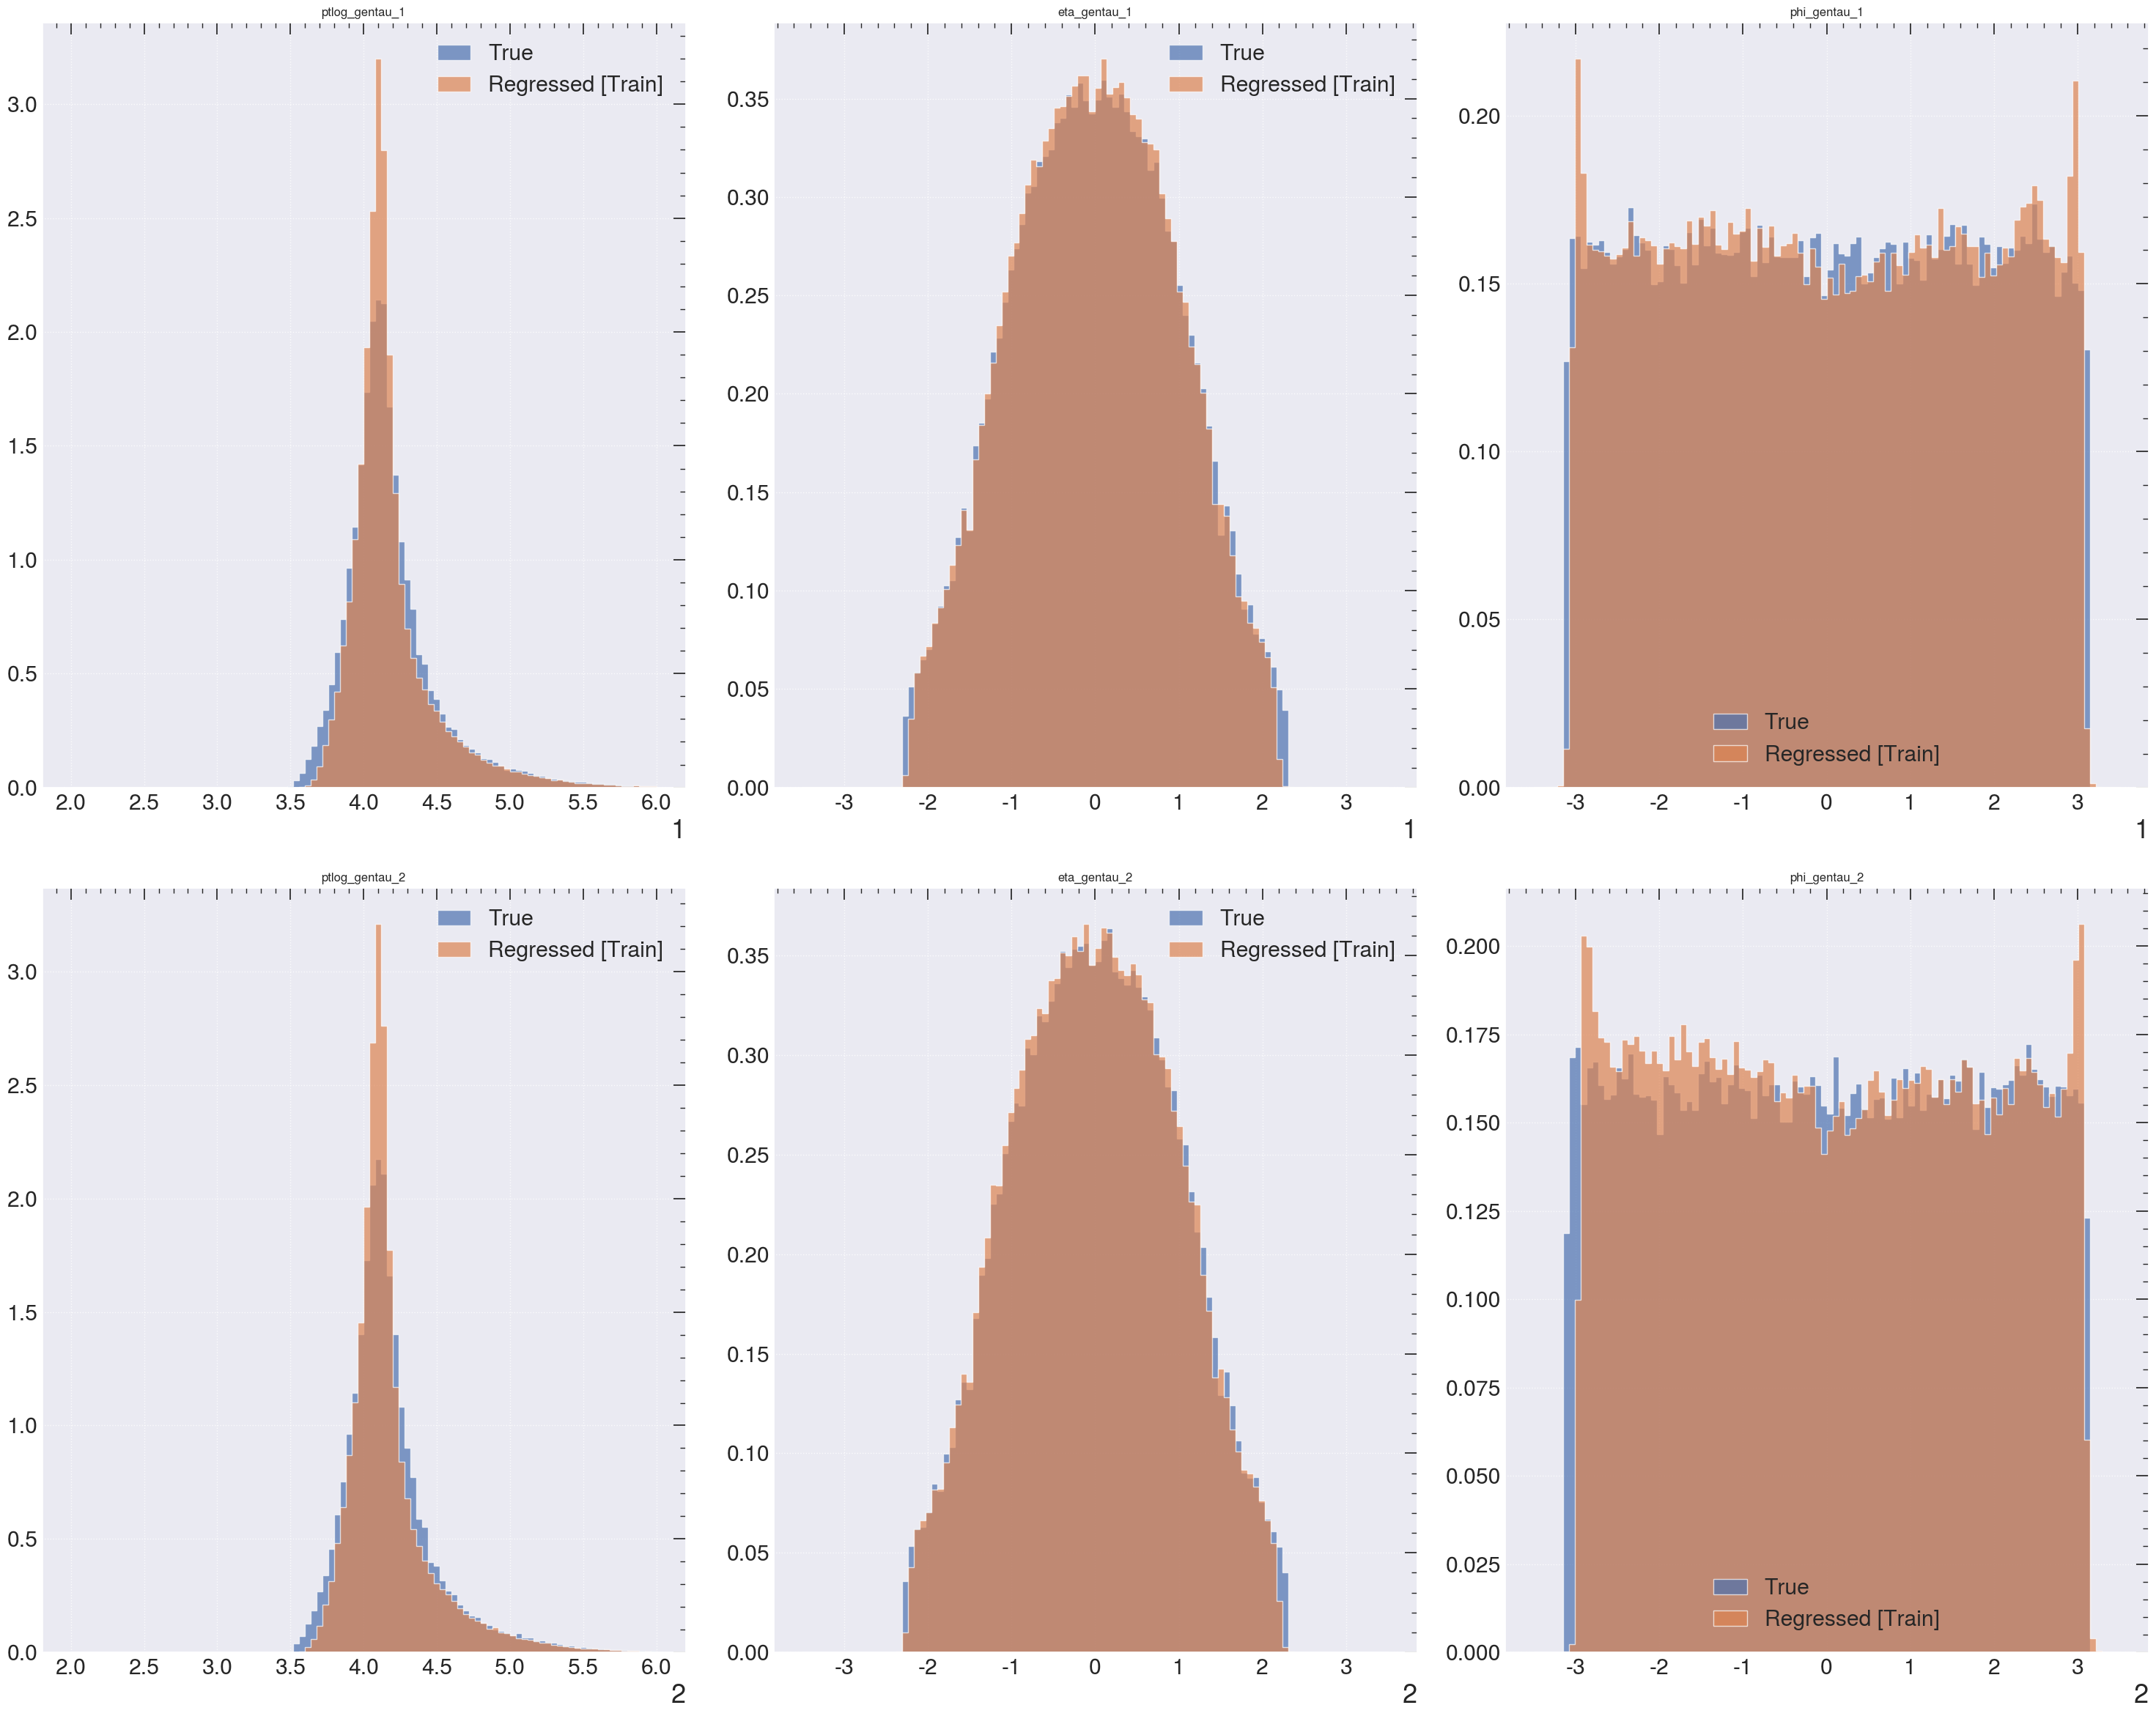

In [ ]:
plt.figure(figsize=(30,24))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr_true = target_val_train[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_train[:,(idx-1):idx].reshape(-1)

    #print(arr)
    #minmax = [-50,50] if np.min(arr_true) < 0 else [0,1]
    minmax = [2,6] if idx == 1 or idx == 4 else [-3.5,3.5]
    ax.hist(arr_true, 100, histtype="stepfilled", alpha=0.7, label='True', 
            log=False, density=True, range=minmax)
    ax.hist(arr_pred, 100, histtype="stepfilled", alpha=0.7, label='Regressed [Train]', 
            log=False, density=True, range=minmax)
    ax.set_title(f"{key}")
    ax.set_xlabel(f'''{key.split('_')[-1]}''')
    ax.legend()

pngname = os.path.join(tagdir,f'output_train_{df_tag_}.png')
logger.info(f"Plot saved: {pngname}")
plt.tight_layout()
plt.savefig(pngname, dpi=300)

In [ ]:
"""
plt.figure(figsize=(20,16))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr_true = target_val_train[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_train[:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [0,50] #if idx%4 == 0 else [0,50]
    ax.hist(np.abs(arr_true), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='True')
    ax.hist(np.abs(arr_pred), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='Regressed [Train]')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"{key.split('_')[-1]}")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_train_abs.png'), dpi=300)
"""

In [65]:
df_test["pt_gentau_1"].to_numpy()
gentau1p4 = vector.array({"pt" : df_test["pt_gentau_1"].to_numpy(),
                          "eta": df_test["eta_gentau_1"].to_numpy(),
                          "phi": df_test["phi_gentau_1"].to_numpy(),
                          "mass": 1.777*np.ones(df_test.shape[0])})
gentau2p4 = vector.array({"pt" : df_test["pt_gentau_2"].to_numpy(),
                          "eta": df_test["eta_gentau_2"].to_numpy(),
                          "phi": df_test["phi_gentau_2"].to_numpy(),
                          "mass": 1.777*np.ones(df_test.shape[0])})
genhp4 = gentau1p4 + gentau2p4

In [66]:
genhp4.mass

array([125.08740063, 125.10271282, 125.01981917, ..., 124.89053978,
       124.94864694, 125.05189689])

In [67]:
regr_tau1_p4 = vector.array({"pt" : np.exp(target_regr[:,:1]).reshape(-1),
                             "eta": target_regr[:,1:2].reshape(-1),
                             "phi": target_regr[:,2:3].reshape(-1),
                             "mass": 1.777*np.ones_like(target_regr[:,:1].reshape(-1))})
regr_tau2_p4 = vector.array({"pt" : np.exp(target_regr[:,3:4]).reshape(-1),
                             "eta": target_regr[:,4:5].reshape(-1),
                             "phi": target_regr[:,5:6].reshape(-1),
                             "mass": 1.777*np.ones_like(target_regr[:,:1].reshape(-1))})

In [68]:
"""
regr_tau1_p4 = vector.array({"px": target_regr[:,:1].reshape(-1),
                             "py": target_regr[:,1:2].reshape(-1),
                             "pz": target_regr[:,2:3].reshape(-1),
                             "M" : 1.777*np.ones_like(target_regr[:,:1].reshape(-1))})
regr_tau2_p4 = vector.array({"px": target_regr[:,3:4].reshape(-1),
                             "py": target_regr[:,4:5].reshape(-1),
                             "pz": target_regr[:,5:6].reshape(-1),
                             "M" : 1.777*np.ones_like(target_regr[:,:1].reshape(-1))})
"""

'\nregr_tau1_p4 = vector.array({"px": target_regr[:,:1].reshape(-1),\n                             "py": target_regr[:,1:2].reshape(-1),\n                             "pz": target_regr[:,2:3].reshape(-1),\n                             "M" : 1.777*np.ones_like(target_regr[:,:1].reshape(-1))})\nregr_tau2_p4 = vector.array({"px": target_regr[:,3:4].reshape(-1),\n                             "py": target_regr[:,4:5].reshape(-1),\n                             "pz": target_regr[:,5:6].reshape(-1),\n                             "M" : 1.777*np.ones_like(target_regr[:,:1].reshape(-1))})\n'

In [69]:
regr_tau1_p4.M, regr_tau2_p4.M

(array([1.777, 1.777, 1.777, ..., 1.777, 1.777, 1.777], dtype=float32),
 array([1.777, 1.777, 1.777, ..., 1.777, 1.777, 1.777], dtype=float32))

In [70]:
regr_h_p4 = regr_tau1_p4 + regr_tau2_p4
regr_h_p4.M

array([122.121124, 125.21579 , 124.61626 , ..., 123.77834 , 124.34368 ,
       125.28931 ], dtype=float32)

2024-05-01:14:21:47,613 INFO     [186737635.py:11] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/mass_tau_tau_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


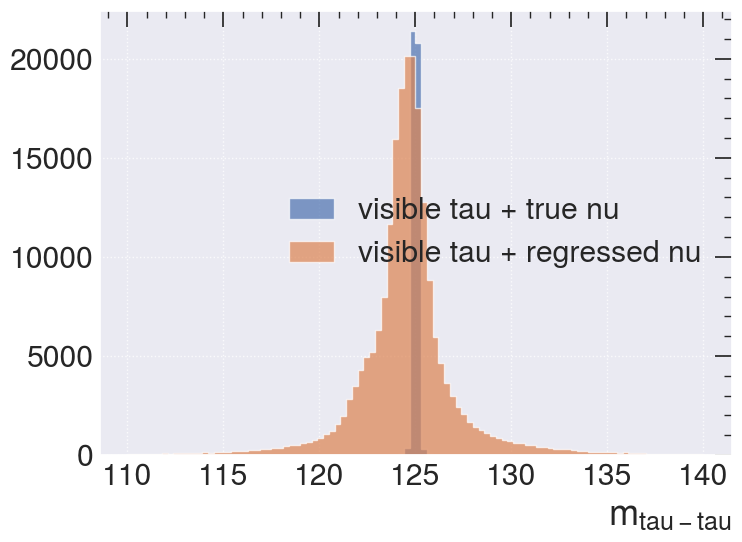

In [71]:
plt.figure(figsize=(8,6))

plt.hist(genhp4.mass, range=[110,140], bins=100, histtype="stepfilled", alpha=0.7, label="visible tau + true nu")
plt.hist(regr_h_p4.M, range=[110,140], bins=100, histtype="stepfilled", alpha=0.7, label="visible tau + regressed nu")
plt.xlabel("$m_{tau-tau}$")
plt.legend()


plt.tight_layout()
pngname = os.path.join(tagdir,f'mass_tau_tau_{df_tag_}.png')
logger.info(f"Plot saved: {pngname}")
plt.savefig(pngname, dpi=300)
plt.show()

In [72]:
pi1_p4 = getp4(df, vars=["pt_tau1pi_1","eta_tau1pi_1","phi_tau1pi_1","mass_tau1pi_1"], LVtype="ptetaphim")
pi2_p4 = getp4(df, vars=["pt_tau2pi_1","eta_tau2pi_1","phi_tau2pi_1","mass_tau2pi_1"], LVtype="ptetaphim")
pi01_p4 = getp4(df, vars=["pt_tau1pi0_1","eta_tau1pi0_1","phi_tau1pi0_1","mass_tau1pi0_1"], LVtype="ptetaphim")
pi02_p4 = getp4(df, vars=["pt_tau2pi0_1","eta_tau2pi0_1","phi_tau2pi0_1","mass_tau2pi0_1"], LVtype="ptetaphim")

In [73]:
import awkward as ak
from coffea.nanoevents.methods import vector
def getakp4(tau1_full_p4, pid):
    return ak.zip(
        {
            "pt": ak.Array(tau1_full_p4.pt[:,None]),
            "eta": ak.Array(tau1_full_p4.eta[:,None]),
            "phi": ak.Array(tau1_full_p4.phi[:,None]),
            "mass": ak.Array(tau1_full_p4.mass[:,None]),
            "pdgId": pid*ak.ones_like(ak.Array(tau1_full_p4.mass[:,None])),
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior
    )

In [74]:
tau1_full_p4 = getakp4(regr_tau1_p4, 15)
tau2_full_p4 = getakp4(regr_tau2_p4, 15)
pi1_p4 = getakp4(pi1_p4, 211)
pi2_p4 = getakp4(pi2_p4, 211)
pi01_p4 = getakp4(pi01_p4, 111)
pi02_p4 = getakp4(pi02_p4, 111)

In [75]:
# Construct H mass from tau visible from the decay products pion and pi0
tau1p4_vis = pi1_p4 + pi01_p4
tau2p4_vis = pi2_p4 + pi02_p4
Hp4_vis = tau1p4_vis + tau2p4_vis



2024-05-01:14:21:48,830 INFO     [1033805282.py:10] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/mass_tau_tau_vis_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


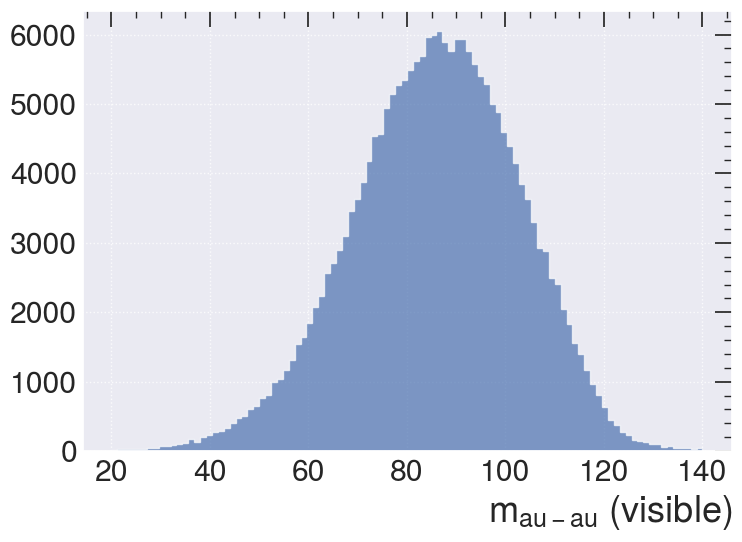

In [76]:
plt.figure(figsize=(8,6))

plt.hist(Hp4_vis.mass, range=[20,140], bins=100, histtype="stepfilled", alpha=0.7)
#plt.hist(regr_h_p4.M, range=[110,140], bins=100, histtype="stepfilled", alpha=0.7, label="visible tau + regressed nu")
plt.xlabel("$m_{\tau-\tau}$ (visible)")
#plt.legend()

plt.tight_layout()
pngname = os.path.join(tagdir,f'mass_tau_tau_vis_{df_tag_}.png')
logger.info(f"Plot saved: {pngname}")
plt.savefig(pngname, dpi=300)
plt.show()

2024-05-01:14:21:49,164 INFO     [1967116405.py:11] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/mass_pi0s_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


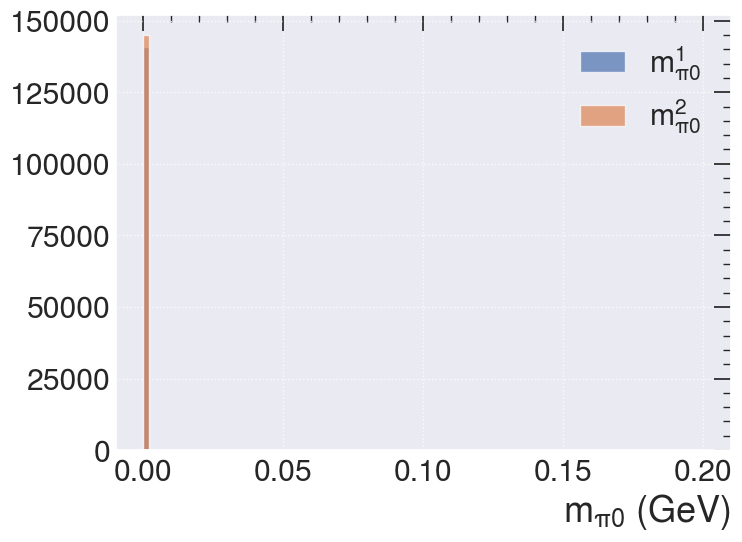

In [77]:
plt.figure(figsize=(8,6))

plt.hist(pi01_p4.mass, range=[0,0.2], bins=100, histtype="stepfilled", alpha=0.7, label="$m_{\pi 0}^1$")
plt.hist(pi02_p4.mass, range=[0,0.2], bins=100, histtype="stepfilled", alpha=0.7, label="$m_{\pi 0}^2$")
#plt.hist(regr_h_p4.M, range=[110,140], bins=100, histtype="stepfilled", alpha=0.7, label="visible tau + regressed nu")
plt.xlabel("$m_{\pi 0}$ (GeV)")
plt.legend()

plt.tight_layout()
pngname = os.path.join(tagdir,f'mass_pi0s_{df_tag_}.png')
logger.info(f"Plot saved: {pngname}")
plt.savefig(pngname, dpi=300)
plt.show()

In [78]:
tau1_full_p4.pt, pi02_p4.pt

(<Array [[52], [64], [61, ... [61.4], [56.9]] type='214825 * 1 * float32'>,
 <Array [[5.37], [5.48], ... [27], [7.45]] type='214825 * 1 * float64'>)

In [79]:
tau1_decay = ak.concatenate([pi1_p4,pi01_p4], axis=1)
tau2_decay = ak.concatenate([pi2_p4,pi02_p4], axis=1)
tau1_decay.pt, tau2_decay.pt

(<Array [[46.1, 9.38], ... [43.1, 14.2]] type='214825 * var * float64'>,
 <Array [[29.7, 5.37], ... [33.9, 7.45]] type='214825 * var * float64'>)

In [80]:
#ak.to_list(tau2_full_p4.pt)

In [81]:
#ak.to_list(tau2_decay.pt)

 --- comp_phiCP --- 
 --- gethvecs --- 
 --- gethvecs_rhorho --- 
Selection of rho-rho pair [mask]: [False, False, False, False, False, False, ... False, False, False, False, False]
n total events: 214825
n selected events: 0
['pt', 'eta', 'phi', 'mass', 'pdgId']
 --- pT  : [[4.55], [10.6], [5.11], [93.1], [5.94], ... [25.8], [131], [13.1], [17.1], [10.5]]
 --- eta : [[-3.5], [3.51], [4.9], [-0.123], [2.74, ... 2.25], [1.3], [-2.13], [-3.49], [-3.68]]
 --- phi : [[0.163], [1.02], [-2.56], [2.47], [2.29, ... [1.82], [0.841], [2.86], [-2.85]]
 --- mass: [[122], [125], [125], [124], [125], [123, ... [124], [122], [124], [124], [125]]
taup p4 + taum p4 ...
    px: [[4.49], [5.56], [-4.26], [-73], [-3.91, ... [-32.1], [8.72], [-16.4], [-10.1]]
    py: [[0.738], [9.07], [-2.82], [57.8], [4.47], ... 25.8], [127], [9.75], [4.69], [-3.07]]
    pz: [[-75.5], [178], [344], [-11.5], [45.7], ... [121], [223], [-54.3], [-279], [-208]]
    E: [[144], [218], [366], [155], [133], [175, ... [175], [286]

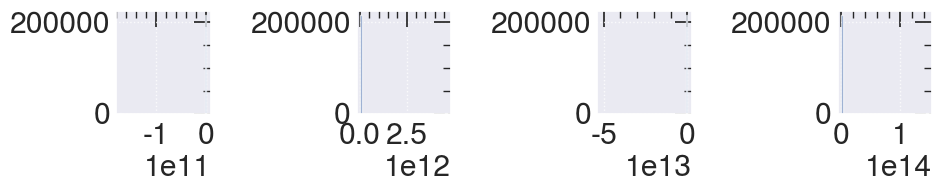

Higgs boost vec: 
    x: [[0.0313], [0.0255], [-0.0117], [-0.47], ... -0.112], [0.0642], [-0.0536], [-0.0414]]
    y: [[0.00514], [0.0416], [-0.00771], [0.372], ... 0.445], [0.0718], [0.0153], [-0.0126]]
    z: [[-0.526], [0.817], [0.94], [-0.0738], ... [0.779], [-0.4], [-0.912], [-0.856]]
 ---> Plotting ---> 


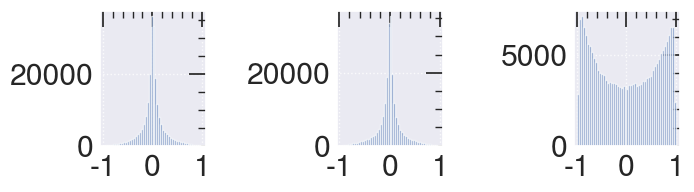

 --- gethvec_rho --- 
Lab frame: 
  Tau: 
    px: [[-41.9], [63.2], [-20], [-63.7], [-60.7], ... [-40.9], [-79], [59.3], [3.21], [24]]
    py: [[-30.8], [-10.1], [57.6], [-25.7], [-13.5, ... -34.8], [75], [4.76], [61.3], [51.6]]
    pz: [[-3.22], [78.7], [195], [-17.9], [9.09], ... [46.4], [142], [2.52], [-102], [-130]]
    E: [[52.1], [101], [205], [71], [62.9], [129, ... [71], [179], [59.6], [119], [142]]
 ---> Plotting ---> 


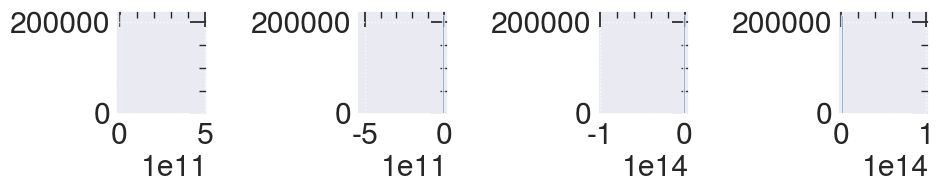

  Pi: 
    px: [[38.9], [-6.92], [-10.3], [-4.33], ... [-4.61], [3.19], [-0.0446], [-25.5]]
    py: [[24.8], [2.35], [32.1], [47.7], [-8.92, ... 6.99], [4.24], [0.521], [7.94], [-34.7]]
    pz: [[-58.6], [13.4], [115], [3.91], [8.93], ... [8.82], [8.95], [0.265], [-13.9], [-52]]
    E: [[74.6], [15.2], [120], [48.1], [49.9], ... [12.2], [10.9], [3.25], [16], [67.5]]
 ---> Plotting ---> 


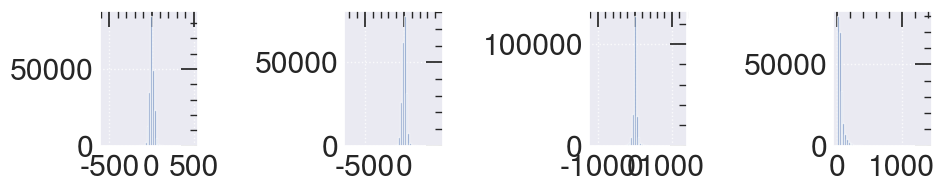

  Pi0: 
    px: [[7.6], [-28.4], [-4.2], [-1.91], [-6.97, ... 29], [-37.9], [49.7], [0.613], [-8.56]]
    py: [[5.5], [8.88], [14.5], [25.3], [-1.41], ... [41.8], [36.8], [7.14], [26.4], [-11.3]]
    pz: [[-11.9], [52.6], [51.9], [1.78], [1.17], ... [53.9], [72.7], [2.37], [-48], [-17.8]]
    E: [[15.1], [60.4], [54.1], [25.4], [7.21], ... [74.2], [89.8], [50.3], [54.8], [22.8]]
 ---> Plotting ---> 


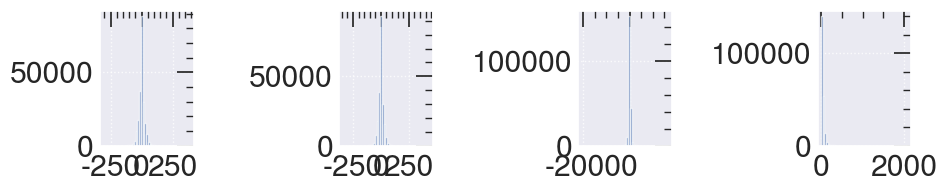

Rest frame: 
  Tau: 
    px: [[-43.8], [60.6], [-17.7], [-28.9], [-58.8, ... [-60.2], [55.2], [10.1], [29.6]]
    py: [[-31.1], [-14.4], [59.2], [-53.2], [-15.7, ... [0.145], [0.194], [59.3], [53.3]]
    pz: [[28.9], [-6.42], [8.09], [-12.4], [-13.1, ... [11.1], [27.9], [15.5], [-14.2]]
    E: [[61.1], [62.6], [62.3], [61.9], [62.3], ... [62.2], [61.2], [61.9], [62.2], [62.6]]
 ---> Plotting ---> 


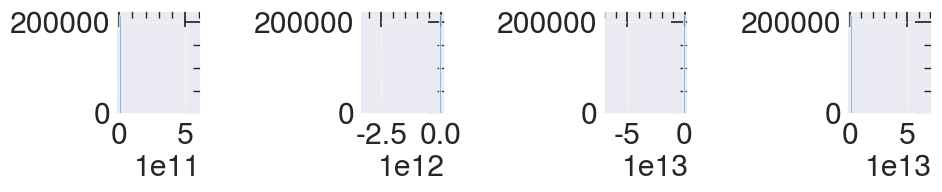

  Pi: 
    px: [[36.8], [-7.29], [-8.96], [17.6], [-46.8, ... [-3.47], [2.97], [0.867], [-22.5]]
    py: [[24.5], [1.74], [33], [30.3], [-10.6, ... 5.34], [-0.289], [0.271], [7.68], [-33.8]]
    pz: [[-23.2], [1.49], [6.53], [7.35], [-8.58], ... 1.05], [1.01], [1.66], [1.58], [9.74]]
    E: [[49.9], [7.65], [34.8], [35.8], [48.8], ... [7.11], [3.63], [3.42], [7.89], [41.8]]
 ---> Plotting ---> 


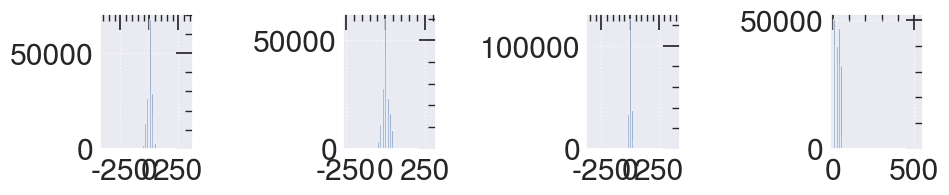

  Pi0: 
    px: [[7.17], [-29.9], [-3.59], [9.74], [-6.75], ... 29], [-28.6], [46.3], [3.7], [-7.57]]
    py: [[5.43], [6.47], [14.9], [16.1], [-1.66], ... 31.7], [-0.369], [3.29], [25.5], [-11]]
    pz: [[-4.69], [5.16], [3.08], [3.61], [-1.37], ... [6.5], [7.51], [23.8], [4.54], [2.78]]
    E: [[10.1], [31], [15.6], [19.1], [7.09], ... [43.5], [29.5], [52.2], [26.2], [13.7]]
 ---> Plotting ---> 


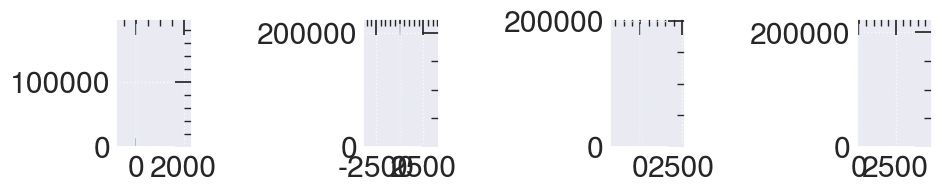

  Pi-Pi0: 
    px: [[29.6], [22.6], [-5.37], [7.87], [-40.1, ... [25.1], [-43.3], [-2.83], [-14.9]]
    py: [[19], [-4.72], [18.2], [14.3], [-8.98, ... [0.0798], [-3.02], [-17.9], [-22.8]]
    pz: [[-18.5], [-3.67], [3.45], [3.74], [-7.21, ... [-6.5], [-22.1], [-2.96], [6.96]]
    E: [[39.8], [-23.4], [19.2], [16.7], [41.7, ... [-25.9], [-48.7], [-18.3], [28.1]]
 ---> Plotting ---> 


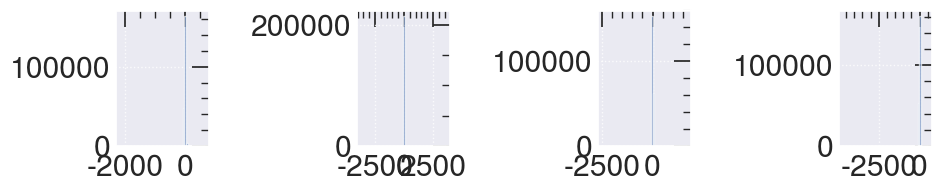

hvec raw: [[{x: -2.85e+05, y: -1.83e+05, z: 1.79e+05}], ... y: 1.51e+05, z: -4.61e+04}]]
    x: [[-2.85e+05], [1.07e+05], [-2.44e+03], ... [2.61e+04], [2.89e+03], [9.89e+04]]
    y: [[-1.83e+05], [-2.23e+04], [8.26e+03], ... [1.82e+03], [1.82e+04], [1.51e+05]]
    z: [[1.79e+05], [-1.73e+04], [1.57e+03], ... [1.34e+04], [3.03e+03], [-4.61e+04]]
 ---> Plotting ---> 


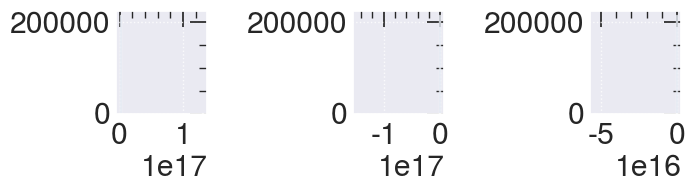

mag: [[3.83e+05], [1.1e+05], [8.76e+03], ... [2.94e+04], [1.87e+04], [1.86e+05]]
 ---> Plotting ---> 


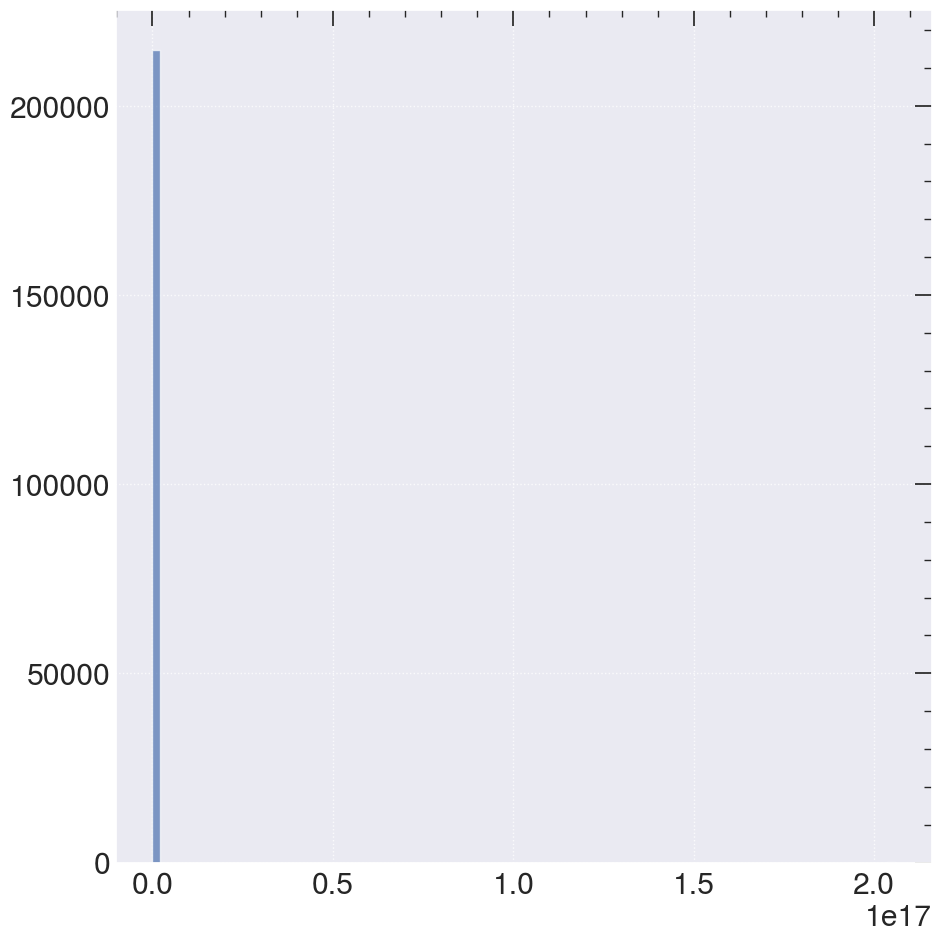

 --- gethvec_rho --- 
Lab frame: 
  Tau: 
    px: [[46.4], [-57.7], [15.8], [-9.35], [56.8, ... 40.9], [47], [-50.6], [-19.6], [-34.1]]
    py: [[31.5], [19.2], [-60.4], [83.5], [18], ... [60.6], [52.3], [5], [-56.6], [-54.7]]
    pz: [[-72.3], [99.3], [149], [6.41], [36.6], ... 74.5], [80.8], [-56.8], [-177], [-78.6]]
    E: [[91.5], [116], [161], [84.3], [70], ... [104], [107], [76.2], [187], [102]]
 ---> Plotting ---> 


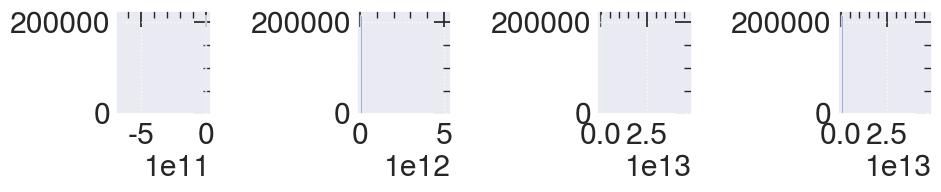

  Pi: 
    px: [[-25], [25.2], [11.3], [-12.3], [14.9, ... -19.6], [24.6], [-26.5], [-2.79], [15.3]]
    py: [[-16], [-2.94], [-41.5], [-4.81], [3.43, ... [31.5], [2.43], [-7.52], [30.3]]
    pz: [[-0.974], [32.2], [105], [-3.08], [10.2, ... 22.1], [50], [-28.9], [-24.1], [-78.2]]
    E: [[29.7], [41], [113], [13.6], [18.3], ... [32.8], [64], [39.3], [25.4], [85.2]]
 ---> Plotting ---> 


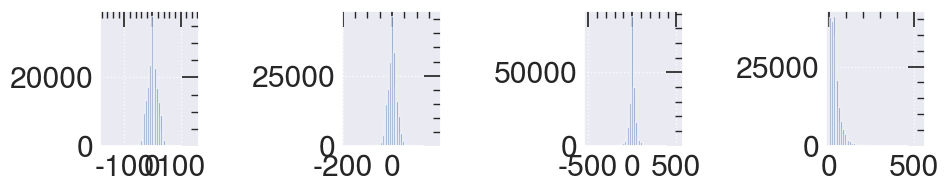

  Pi0: 
    px: [[-4.38], [5.38], [1.07], [-41.8], [36.9, ... [0.814], [-9.87], [-10.4], [-4.39]]
    py: [[-3.1], [-1.04], [-4.23], [-15], [8.9], ... 17.7], [1.18], [0.342], [-24.9], [6.02]]
    pz: [[0.0482], [7.21], [10.6], [-10.4], [23.7, ... [1.86], [-10.5], [-82.6], [-90.3]]
    E: [[5.37], [9.06], [11.4], [45.6], [44.8], ... [45.5], [2.35], [14.4], [86.9], [90.6]]
 ---> Plotting ---> 


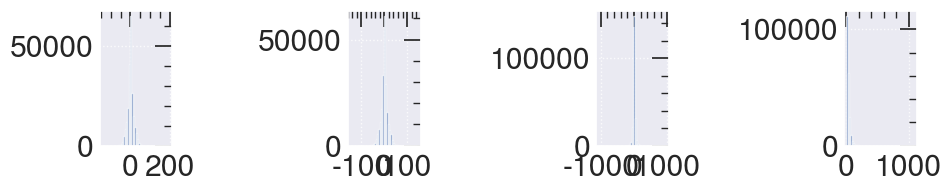

Rest frame: 
  Tau: 
    px: [[43.8], [-60.6], [17.7], [28.9], [58.8, ... [60.2], [-55.2], [-10.1], [-29.6]]
    py: [[31.1], [14.4], [-59.2], [53.2], [15.7, ... [-0.145], [-0.194], [-59.3], [-53.3]]
    pz: [[-28.9], [6.42], [-8.09], [12.4], [13.1, ... [-11.1], [-27.9], [-15.5], [14.2]]
    E: [[61.1], [62.6], [62.3], [61.9], [62.3], ... [62.2], [61.2], [61.9], [62.2], [62.6]]
 ---> Plotting ---> 


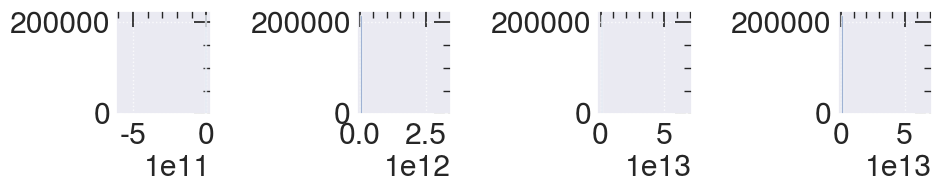

  Pi: 
    px: [[-26.1], [24.2], [12.7], [-5.7], [15.4, ... -19.6], [32.2], [-28.8], [-1.5], [18.7]]
    py: [[-16.2], [-4.68], [-40.6], [-10.1], [2.83, ... [1.48], [-0.245], [-7.89], [31.3]]
    pz: [[17.5], [-1.85], [-4.74], [-2.04], [4.06, ... [-2.55], [-14], [-2.24], [-8.84]]
    E: [[35.4], [24.7], [42.8], [11.7], [16.2], ... [27.8], [32.3], [32.1], [8.34], [37.5]]
 ---> Plotting ---> 


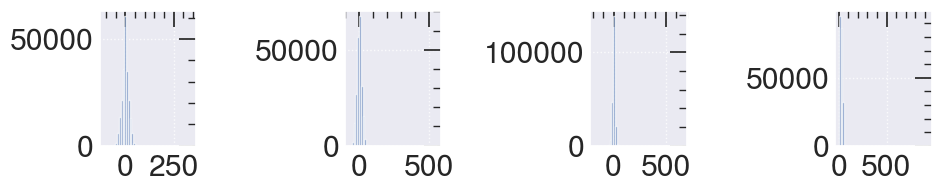

  Pi0: 
    px: [[-4.58], [5.14], [1.2], [-19.8], [38.2], ... 0.508], [1.08], [-10.8], [-6], [-1.22]]
    py: [[-3.14], [-1.42], [-4.14], [-32.5], ... [0.109], [-0.644], [-26.2], [6.98]]
    pz: [[3.43], [-0.26], [-0.503], [-6.9], ... [-0.0153], [-4.97], [-8.06], [-24.6]]
    E: [[6.53], [5.34], [4.34], [38.6], [39.9], ... [19.8], [1.09], [11.9], [28], [25.6]]
 ---> Plotting ---> 


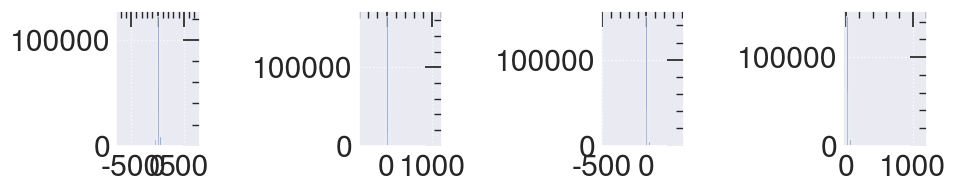

  Pi-Pi0: 
    px: [[-21.5], [19], [11.5], [14.1], [-22.8], ... [-20.1], [31.1], [-18.1], [4.5], [19.9]]
    py: [[-13.1], [-3.26], [-36.5], [22.4], [-4.6, ... [1.37], [0.399], [18.3], [24.3]]
    pz: [[14.1], [-1.59], [-4.24], [4.86], [-4.65, ... [-2.54], [-9.01], [5.83], [15.8]]
    E: [[28.8], [19.3], [38.5], [-26.9], [-23.7, ... 8.04], [31.2], [20.2], [-19.7], [11.9]]
 ---> Plotting ---> 


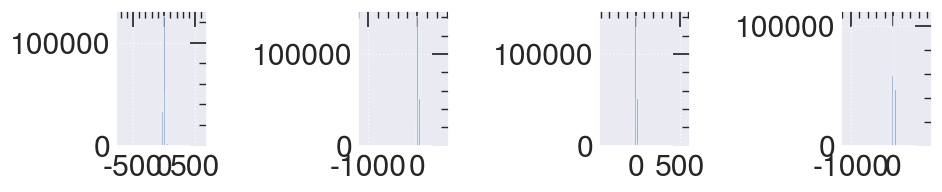

hvec raw: [[{x: 1.28e+05, y: 7.75e+04, z: -8.37e+04}], ... y: -2.18e+05, z: -2.39e+04}]]
    x: [[1.28e+05], [-6.81e+04], [1.33e+04], ... [-1.32e+04], [-4.53e+03], [-1.48e+05]]
    y: [[7.75e+04], [1.17e+04], [-4.24e+04], ... [291], [-1.84e+04], [-2.18e+05]]
    z: [[-8.37e+04], [5.71e+03], [-4.92e+03], ... [-6.56e+03], [-5.88e+03], [-2.39e+04]]
 ---> Plotting ---> 


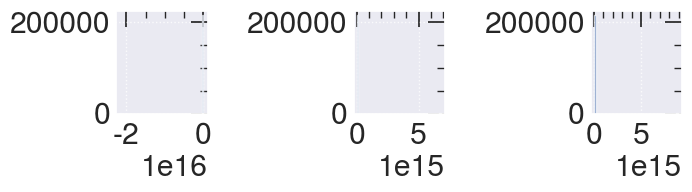

mag: [[1.71e+05], [6.93e+04], [4.47e+04], ... [1.47e+04], [1.99e+04], [2.64e+05]]
 ---> Plotting ---> 


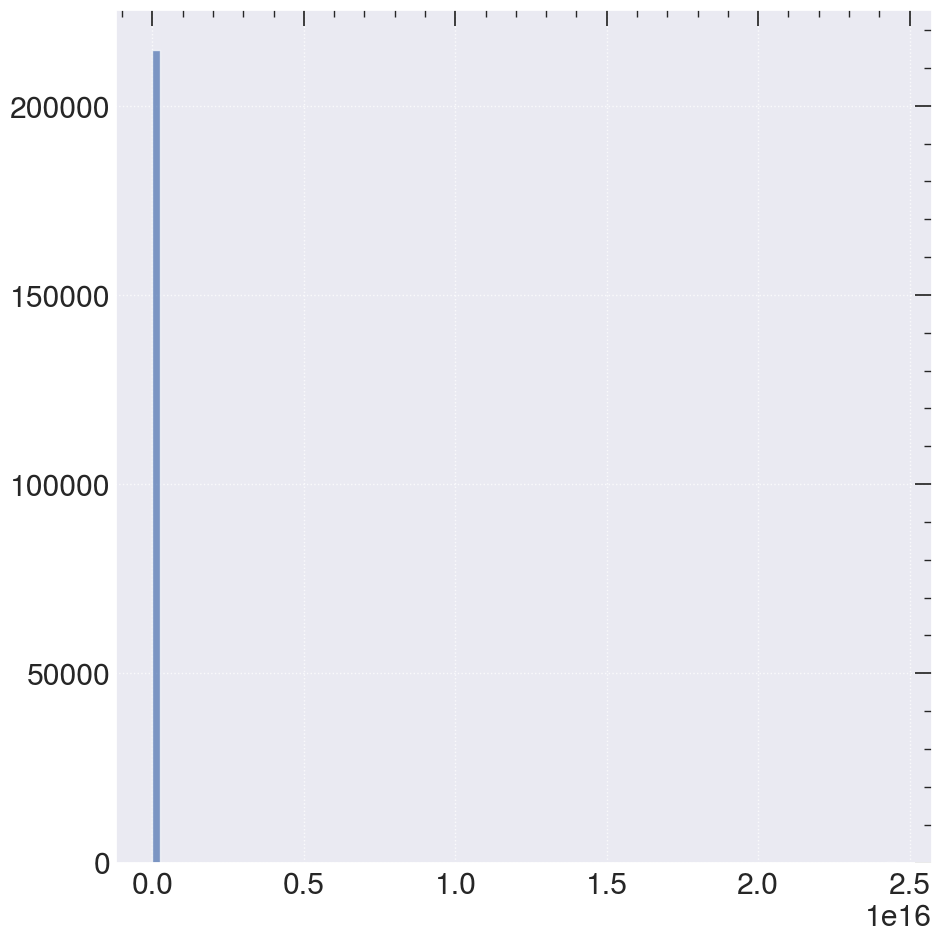

h1: unitvec
    x: [[-0.744], [0.967], [-0.279], [-0.471], ... [-0.968], [0.889], [0.155], [0.531]]
    y: [[-0.479], [-0.202], [0.943], [-0.853], ... [-0.00306], [0.062], [0.975], [0.81]]
    z: [[0.466], [-0.157], [0.179], [-0.224], ... [0.251], [0.454], [0.162], [-0.248]]
 ---> Plotting ---> 


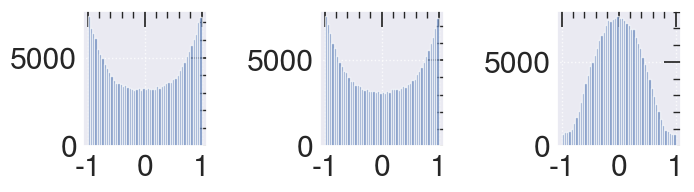

h2: unitvec
    x: [[0.746], [-0.982], [0.298], [0.523], ... [0.996], [-0.895], [-0.228], [-0.559]]
    y: [[0.452], [0.169], [-0.948], [0.833], ... [0.0439], [0.0198], [-0.928], [-0.824]]
    z: [[-0.489], [0.0824], [-0.11], [0.181], ... [-0.0813], [-0.446], [-0.296], [-0.0906]]
 ---> Plotting ---> 


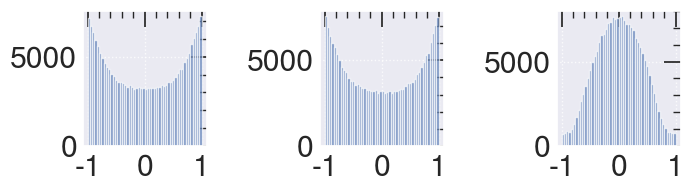

tau- hrest unit
    x: [[-0.718], [0.968], [-0.285], [-0.467], ... [-0.984], [0.892], [0.163], [0.473]]
    y: [[-0.509], [-0.231], [0.95], [-0.861], ... [0.00237], [0.00313], [0.955], [0.851]]
    z: [[0.474], [-0.103], [0.13], [-0.201], ... [0.181], [0.451], [0.249], [-0.227]]
 ---> Plotting ---> 


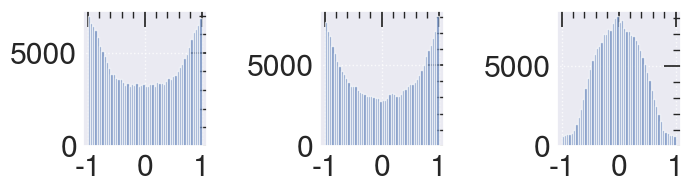

tau+ hrest unit
    x: [[0.718], [-0.968], [0.285], [0.467], ... [0.984], [-0.892], [-0.163], [-0.473]]
    y: [[0.509], [0.231], [-0.95], [0.861], ... [-0.00237], [-0.00313], [-0.955], [-0.851]]
    z: [[-0.474], [0.103], [-0.13], [0.201], ... [-0.181], [-0.451], [-0.249], [0.227]]
 ---> Plotting ---> 


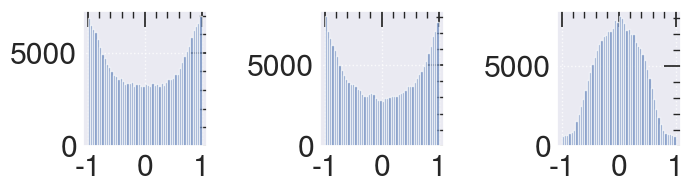

k1raw
    x: [[0.0102], [-0.0155], [-0.0473], [-0.0215, ... [0.0265], [0.0885], [0.0268]]
    y: [[0.0181], [-0.0528], [-0.0147], [0.0101, ... [0.00412], [-0.0122], [0.00345]]
    z: [[0.0349], [-0.0273], [0.00353], [0.00669, ... [-0.0525], [-0.0112], [0.0688]]
 ---> Plotting ---> 


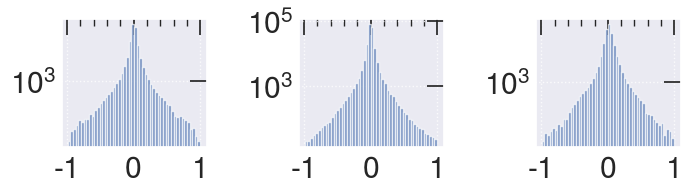

k2raw
    x: [[0.0341], [-0.00174], [0.0188], [0.0117, ... [-0.0103], [-0.0509], [-0.264]]
    y: [[0.00306], [0.0209], [0.00744], [-0.0205, ... [-0.00626], [-0.00875], [0.17]]
    z: [[0.055], [-0.0635], [-0.0133], [0.0605], ... -0.0455], [0.0204], [0.0667], [0.0861]]
 ---> Plotting ---> 


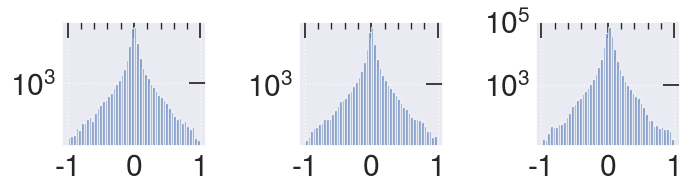

k1: unitvec
    x: [[0.252], [-0.252], [-0.953], [-0.871], ... [-0.016], [0.45], [0.983], [0.363]]
    y: [[0.445], [-0.859], [-0.295], [0.409], ... [-0.997], [0.0699], [-0.135], [0.0467]]
    z: [[0.859], [-0.445], [0.0711], [0.272], ... [-0.0739], [-0.89], [-0.124], [0.931]]
 ---> Plotting ---> 


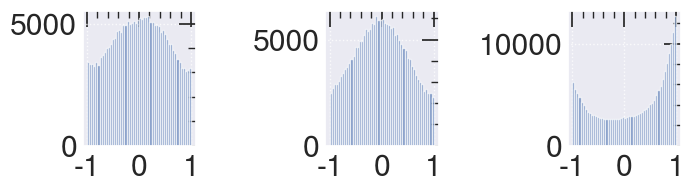

k2: unitvec
    x: [[0.527], [-0.0259], [0.776], [0.181], ... [-0.0738], [-0.435], [-0.603], [-0.811]]
    y: [[0.0473], [0.313], [0.308], [-0.315], ... [0.908], [-0.264], [-0.104], [0.521]]
    z: [[0.849], [-0.949], [-0.551], [0.932], ... [-0.414], [0.861], [0.791], [0.264]]
 ---> Plotting ---> 


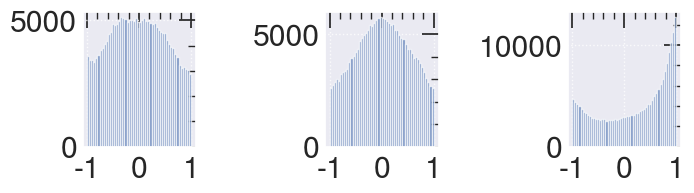

 -- Check -- : -- Strat --
 -- cosine angle between hi and tau+- 
 ---> Plotting ---> 


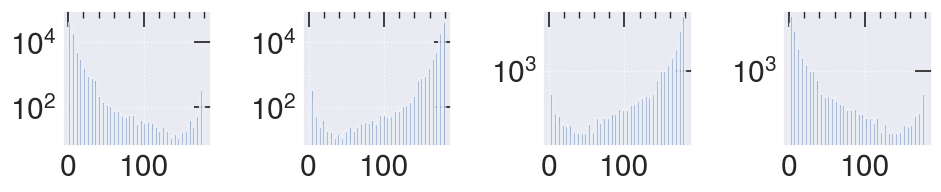

 -- h1xh2 --
    x: [[0.023], [0.00978], [0.0658], [0.0324], ... -0.0108], [-0.0366], [-0.138], [-0.277]]
    y: [[-0.0157], [0.0745], [0.0226], [-0.0319], ... 0.171], [-0.0104], [0.00876], [0.186]]
    z: [[0.0207], [-0.0357], [-0.0168], [0.0535], ... [-0.0394], [0.073], [0.079], [0.0154]]
 ---> Plotting ---> 


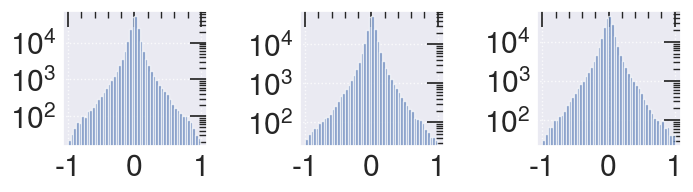

h1xh2.dot(p4_taum_hrest.pvec.unit) : h1xh2.dot(p4_taup_hrest.pvec.unit)
 ---> Plotting ---> 


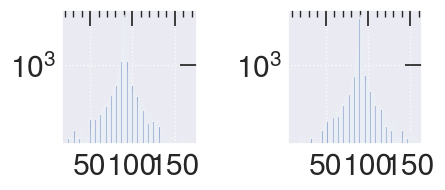

 -- Check -- : -- End --
Angle: [[0.00124], [-0.00405], [0.000594], [0.0016, ... [0.000274], [0.00559], [0.0241]]
 ---> Plotting ---> 


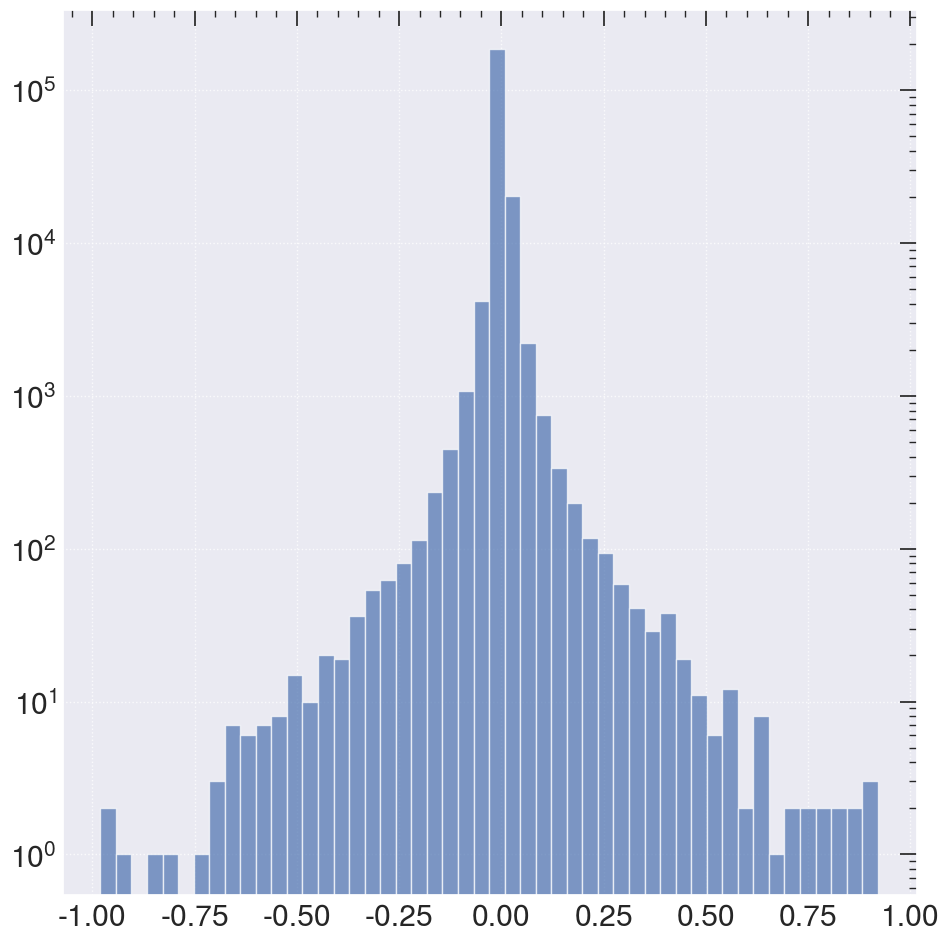

 ---> Plotting ---> 


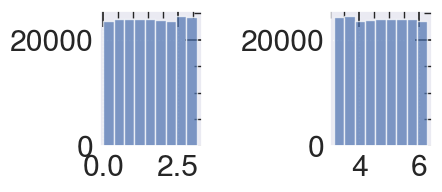

PhiCP: [[5.79], [1.41], [3.66], [4.68], [0.53], ... [0.972], [3.65], [3.34], [3.97], [4.69]]
 ---> Plotting ---> 


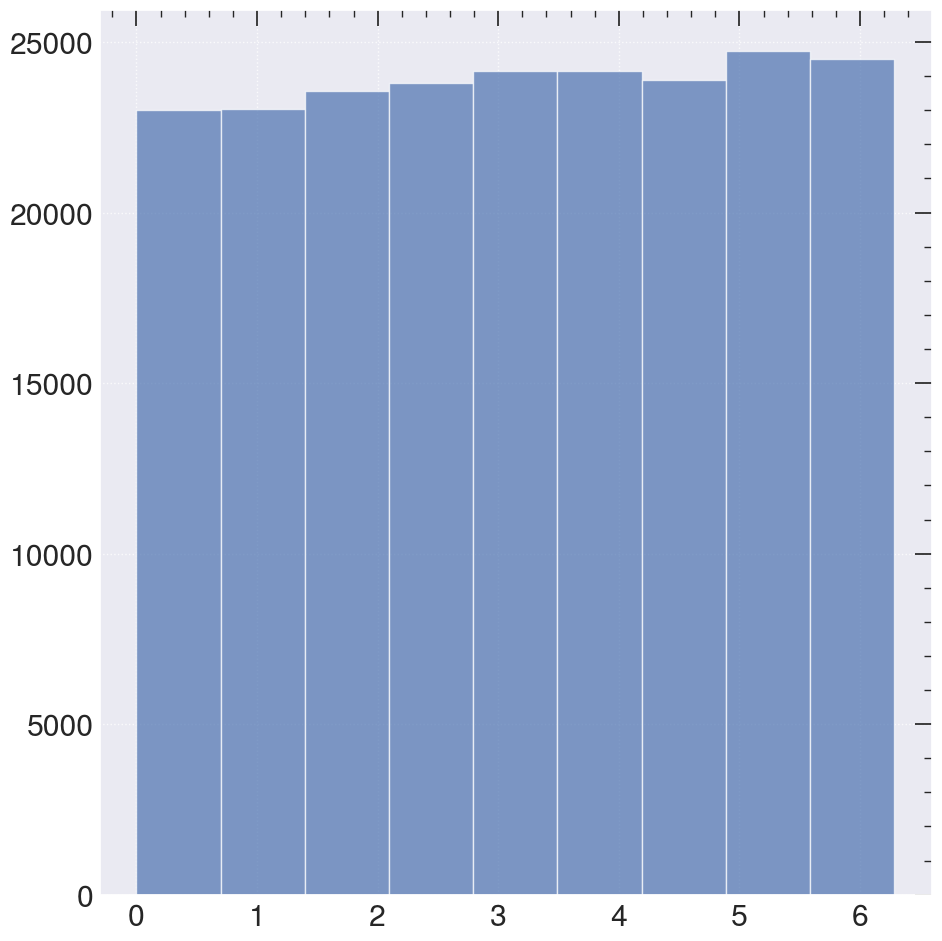

<Array [5.79, 1.41, 3.66, ... 3.34, 3.97, 4.69] type='214825 * ?float64'>

In [82]:
from PhiCPComp import PhiCPComp
phicp_obj = PhiCPComp(cat="rhorho",
                      taum=tau1_full_p4,
                      taup=tau2_full_p4,
                      taum_decay=tau1_decay,
                      taup_decay=tau2_decay)
phi_cp, hk_dict = phicp_obj.comp_phiCP()
phi_cp = ak.firsts(phi_cp, axis=1)
phi_cp

In [83]:
phicp_det = phi_cp
phicp_gen = ak.Array(df["phicp"])
phicp_det_true_tau = ak.Array(df["phi_cp_det"])
phicp_det, phicp_gen, phicp_det_true_tau

(<Array [5.79, 1.41, 3.66, ... 3.34, 3.97, 4.69] type='214825 * ?float64'>,
 <Array [6.12, 1.93, 2.03, ... 4.45, 4.48, 2.48] type='214825 * float64'>,
 <Array [0.000285, 4.39, 2.19, ... 4.73, 2.91] type='214825 * float64'>)

2024-05-01:14:22:02,072 INFO     [1943445177.py:9] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/PhiCP_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


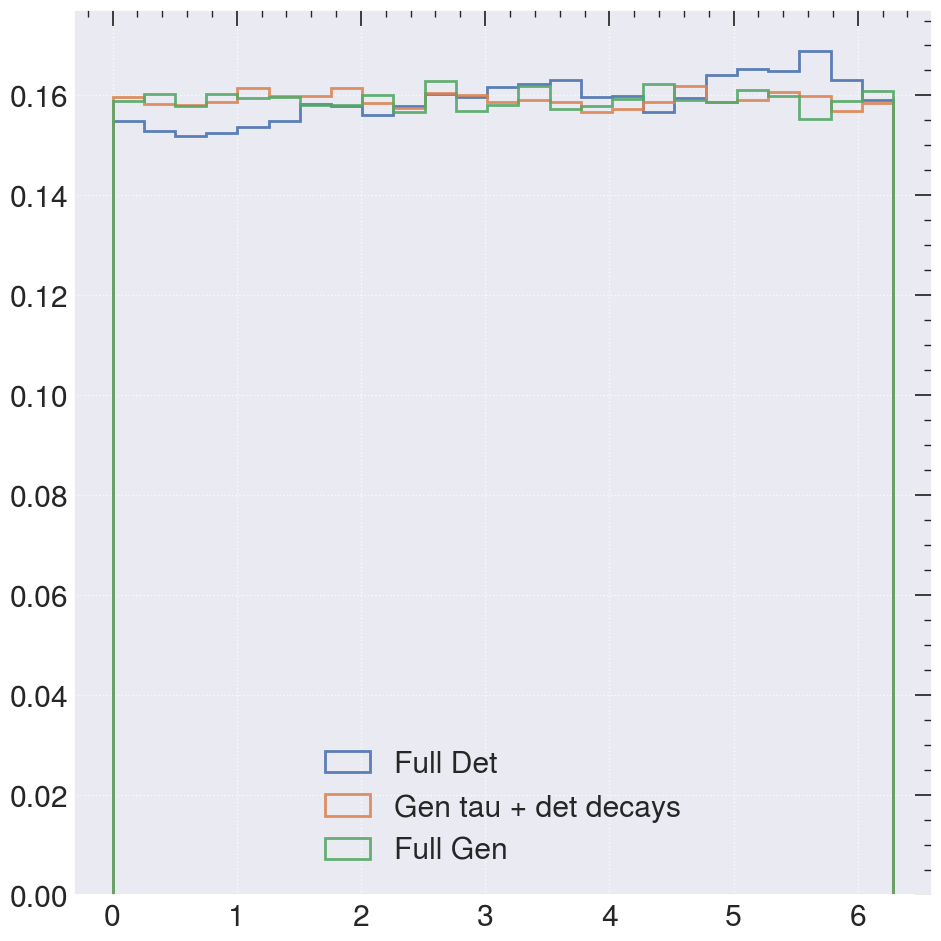

In [84]:
#plt.figure(12,8)
plt.hist(ak.to_numpy(phicp_det), bins=25, label="Full Det", density=True, alpha=0.9, lw=2, histtype="step")
plt.hist(ak.to_numpy(phicp_det_true_tau), bins=25, label="Gen tau + det decays", density=True, alpha=0.9, lw=2, histtype="step")
plt.hist(ak.to_numpy(phicp_gen), bins=25, label="Full Gen", density=True, alpha=0.9, lw=2, histtype="step")

plt.legend()
plt.tight_layout()
pngname = os.path.join(tagdir,f'PhiCP_{df_tag_}.png')
logger.info(f"Plot saved: {pngname}")
plt.savefig(pngname, dpi=300)
plt.show()

In [85]:
hk_dict

{'h1_unit': <ThreeVectorArray [[{x: -0.744, ... z: -0.248}]] type='214825 * var * ThreeVecto...'>,
 'h2_unit': <ThreeVectorArray [[{x: 0.746, y: 0.452, ... z: -0.0906}]] type='214825 * var * ...'>,
 'k1_unit': <ThreeVectorArray [[{x: 0.252, y: 0.445, ... z: 0.931}]] type='214825 * var * Th...'>,
 'k2_unit': <ThreeVectorArray [[{x: 0.527, y: 0.0473, ... z: 0.264}]] type='214825 * var * T...'>,
 'k1_raw': <ThreeVectorArray [[{x: 0.0102, ... z: 0.0688}]] type='214825 * var * ThreeVecto...'>,
 'k2_raw': <ThreeVectorArray [[{x: 0.0341, ... z: 0.0861}]] type='214825 * var * ThreeVecto...'>}

In [86]:
conv = lambda x : ak.fill_none(ak.flatten(x),0).to_numpy()

In [87]:
h1_det = hk_dict["h1_unit"]

h1x_det = conv(h1_det.x)
h1x_gen = df["h1x"].to_numpy()
h1y_det = conv(h1_det.y)
h1y_gen = df["h1y"].to_numpy()
h1z_det = conv(h1_det.z)
h1z_gen = df["h1z"].to_numpy()

h2_det = hk_dict["h2_unit"]

h2x_det = conv(h2_det.x)
h2x_gen = df["h2x"].to_numpy()
h2y_det = conv(h2_det.y)
h2y_gen = df["h2y"].to_numpy()
h2z_det = conv(h2_det.z)
h2z_gen = df["h2z"].to_numpy()

k1_det = hk_dict["k1_unit"]

k1x_det = conv(k1_det.x)
k1x_gen = df["k1x"].to_numpy()
k1y_det = conv(k1_det.y)
k1y_gen = df["k1y"].to_numpy()
k1z_det = conv(k1_det.z)
k1z_gen = df["k1z"].to_numpy()

k2_det = hk_dict["k2_unit"]

k2x_det = conv(k2_det.x)
k2x_gen = df["k2x"].to_numpy()
k2y_det = conv(k2_det.y)
k2y_gen = df["k2y"].to_numpy()
k2z_det = conv(k2_det.z)
k2z_gen = df["k2z"].to_numpy()

In [88]:
def fastplot(arrs1, arrs2, tag='h'):
    fig, ax = plt.subplots(2,3,figsize=(12.5,8))

    ax[0,0].hist(arrs1[0], 100, histtype="stepfilled", alpha=0.7, label='Gen', log=False, density=True)
    ax[0,0].hist(arrs2[0], 100, histtype="stepfilled", alpha=0.7, label='Reco', log=False, density=True)
    ax[0,0].set_title(f"{tag}1x")
    ax[0,0].legend()
    
    ax[0,1].hist(arrs1[1], 100, histtype="stepfilled", alpha=0.7, label='Gen', log=False, density=True)
    ax[0,1].hist(arrs2[1], 100, histtype="stepfilled", alpha=0.7, label='Reco', log=False, density=True)
    ax[0,1].set_title(f"{tag}1y")
    ax[0,1].legend()

    ax[0,2].hist(arrs1[2], 100, histtype="stepfilled", alpha=0.7, label='Gen', log=False, density=True)
    ax[0,2].hist(arrs2[2], 100, histtype="stepfilled", alpha=0.7, label='Reco', log=False, density=True)
    ax[0,2].set_title(f"{tag}1z")
    ax[0,2].legend()
    
    ax[1,0].hist(arrs1[3], 100, histtype="stepfilled", alpha=0.7, label='Gen', log=False, density=True)
    ax[1,0].hist(arrs2[3], 100, histtype="stepfilled", alpha=0.7, label='Reco', log=False, density=True)
    ax[1,0].set_title(f"{tag}2x")
    ax[1,0].legend()
    
    ax[1,1].hist(arrs1[4], 100, histtype="stepfilled", alpha=0.7, label='Gen', log=False, density=True)
    ax[1,1].hist(arrs2[4], 100, histtype="stepfilled", alpha=0.7, label='Reco', log=False, density=True)
    ax[1,1].set_title(f"{tag}2y")
    ax[1,1].legend()

    ax[1,2].hist(arrs1[5], 100, histtype="stepfilled", alpha=0.7, label='Gen', log=False, density=True)
    ax[1,2].hist(arrs2[5], 100, histtype="stepfilled", alpha=0.7, label='Reco', log=False, density=True)
    ax[1,2].set_title(f"{tag}2z")
    ax[1,2].legend()

    plt.tight_layout()
    pngname = os.path.join(tagdir,f'{tag}_{df_tag_}.png')
    logger.info(f"Plot saved: {pngname}")
    plt.savefig(pngname, dpi=300)

2024-05-01:14:22:02,777 INFO     [3773892087.py:36] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/h_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


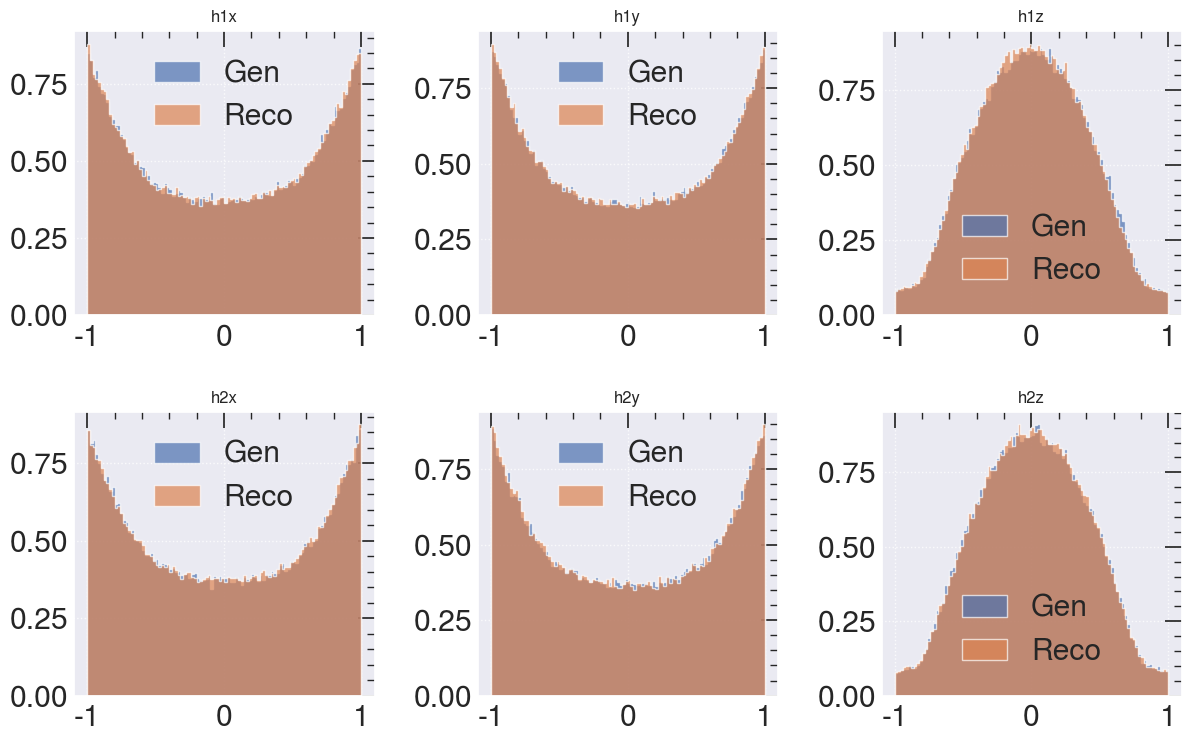

In [89]:
fastplot([h1x_gen,h1y_gen,h1z_gen,h2x_gen,h2y_gen,h2z_gen],
         [h1x_det,h1y_det,h1z_det,h2x_det,h2y_det,h2z_det], tag='h')

2024-05-01:14:22:03,891 INFO     [3773892087.py:36] Plot saved: /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_Flat_May01/k_GluGluHToTauTauFlat_ForTrain_Raw_11_simple_MB_20240501_082908_nPart_10_executed_on_20240501_142119.png


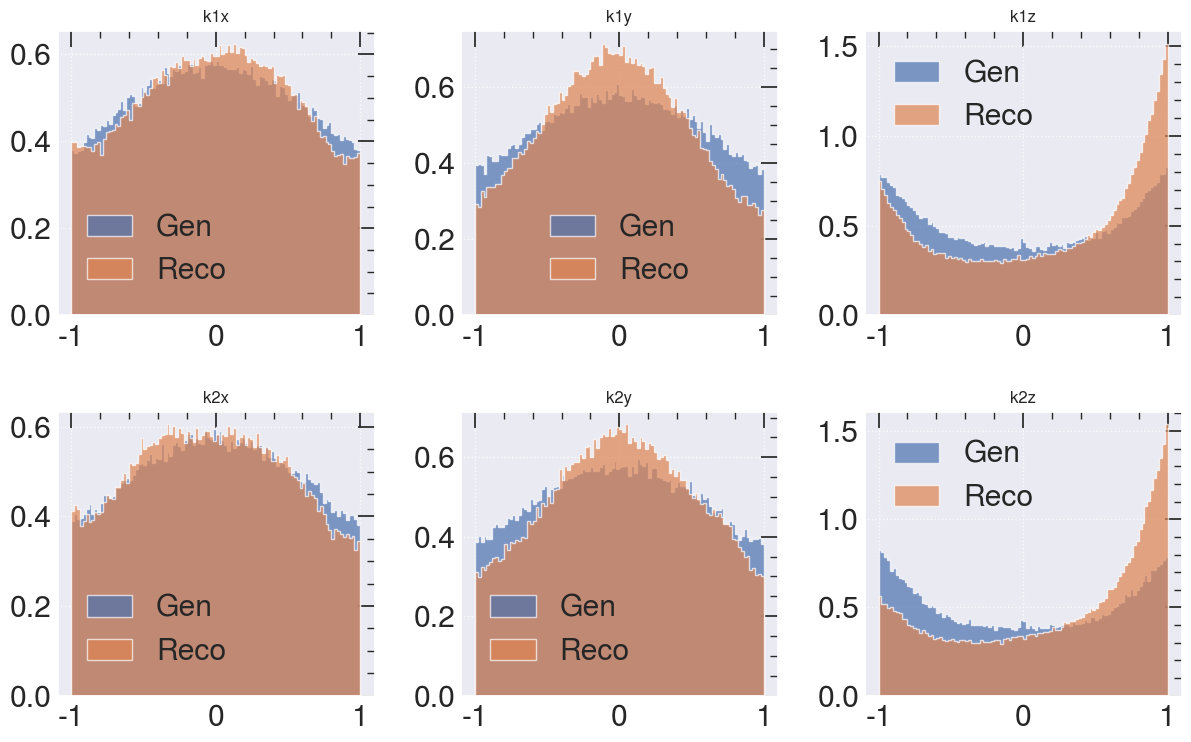

In [ ]:
fastplot([k1x_gen,k1y_gen,k1z_gen,k2x_gen,k2y_gen,k2z_gen],
         [k1x_det,k1y_det,k1z_det,k2x_det,k2y_det,k2z_det], tag='k')